# Check robustness & Enhance results

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [107]:
!pip install imbalanced-learn

## Import data

In [108]:
dataset = pd.read_csv('df_tree.csv')
data_top = dataset.keys()
feature_names = data_top[1:-1]
X = dataset.iloc[:, 1:-1].values.astype('int')
y = dataset.iloc[:, -1].values.astype('int')

## Robustness Checking

In [72]:
n = 100
acc = []
f1 =[]

for rs in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs*1234+567)
    for rs_ in range(n):
        clf = DecisionTreeClassifier(random_state = rs_).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

# print(f'Accuracy scores: {acc}')
# print(f'F1 scores: {f1}')
print(f'Accuracy scores mean: {np.mean(acc)}')
print(f'Accuracy scores standard deviation: {np.std(acc)}')
print(f'F1 scores mean: {np.mean(f1)}')
print(f'F1 scores mean standard deviation: {np.std(f1)}')

Accuracy scores mean: 0.7666864406779661
Accuracy scores standard deviation: 0.05437353055003626
F1 scores mean: 0.34083840230265744
F1 scores mean standard deviation: 0.1301923698517253


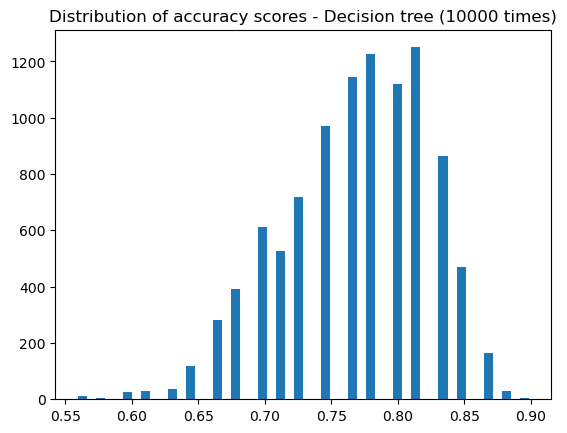

In [5]:
plt.hist(np.array(acc), bins = 50)
#plt.hist(np.array(f1), bins = 80)
plt.title('Distribution of accuracy scores - Decision tree (10000 times)')
#plt.legend(['Acc','F1'])
plt.show()

The accurarcy score from the paper is 78%, which is close to the mean within one standard deviation.

Robustness checked. We further disentangle the effects of data splits and random state:

In [20]:
acc_split_mean = []
f1_split_mean = []
for i in range(100):
    acc_split = np.mean(acc[i*100:i*100+100])
    f1_split = np.mean(f1[i*100:i*100+100])
    acc_split_mean.append(acc_split)
    f1_split_mean.append(f1_split)

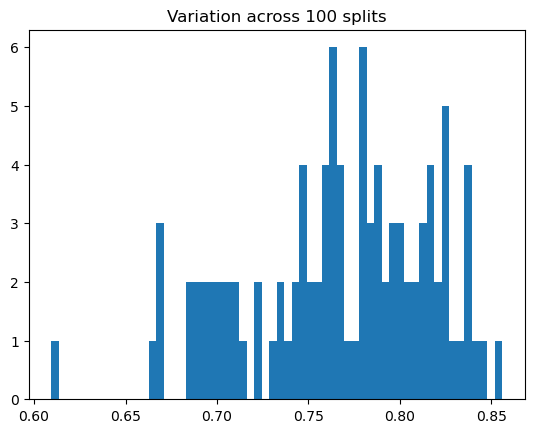

In [58]:
plt.hist(acc_split_mean, bins = 60)
plt.title('Variation across 100 splits')
plt.show()

In [54]:
acc_state_mean = []
f1_state_mean = []
for i in range(100):
    acc_state = np.mean(acc[i::100])
    f1_state = np.mean(f1[i::100])
    acc_state_mean.append(acc_state)
    f1_state_mean.append(f1_state)

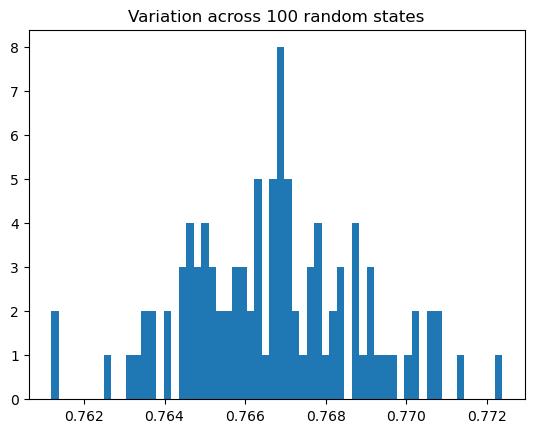

In [59]:
plt.hist(acc_state_mean, bins = 60)
plt.title('Variation across 100 random states')
plt.show()

## Results Enhancement

### Stratified sampling

In the whole dataset, there are 51 positive catalysts and 240 non-positive catalysts. To avoid extremely unbalanced data in training set or testing set due to random split, we use stratified sampling to ensure the same proportion of postive catalysts in training set and testing set with the orignal data set.

In [109]:
dataset_pos = dataset.iloc[y==True,].values.astype('bool')
dataset_neg = dataset.iloc[y==False,].values.astype('bool')
X_pos = dataset_pos[:, 1:-1]
y_pos = dataset_pos[:, -1]
X_neg = dataset_neg[:, 1:-1]
y_neg = dataset_neg[:, -1]

In [110]:
def stratified_sampling (X_pos, X_neg, y_pos, y_neg, rs):
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size = 0.2, random_state = rs)
    X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, test_size = 0.2, random_state = rs)
    X_train = np.concatenate((X_pos_train, X_neg_train), axis=0)
    y_train = np.concatenate((y_pos_train, y_neg_train), axis=0)
    X_test = np.concatenate((X_pos_test, X_neg_test), axis=0)
    y_test = np.concatenate((y_pos_test, y_neg_test), axis=0)
    return X_train, y_train, X_test, y_test

### Resampling

To further overcome the unbalanceness, we resample the training data set (size=232, Pos:Non_Pos = 41:191) through a combination of oversampling and undersampling. We first do oversampling using the most popular method SMOTE with a ratio of 0.6 = (232/2) : 191. This ratio refers to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. We then do random undersampling with a ratio of 1 to ensure equal sample size of two classes.

In [113]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [114]:
# combine SMOTE and random undersampling
def resampling (X, y, overratio, underratio, randomstate):
    X = X.astype(int)
    y = y.astype(int)
    over = SMOTE(sampling_strategy=overratio, random_state=randomstate) # set this value to get similar sample size before and after resampling
    under = RandomUnderSampler(sampling_strategy=underratio, random_state=randomstate) # to get equal sample sizes of two classes
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    X = X.astype(bool)
    y = y.astype(bool)
    return X, y

# summarize the new class distribution
# counter = Counter(y)
# print(counter)

In [1]:
# install skopt package to do hyperparameter tuning
!pip install scikit-optimize

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-23.7.0-py3-none-any.whl (17 kB)


In [2]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

### Decision tree

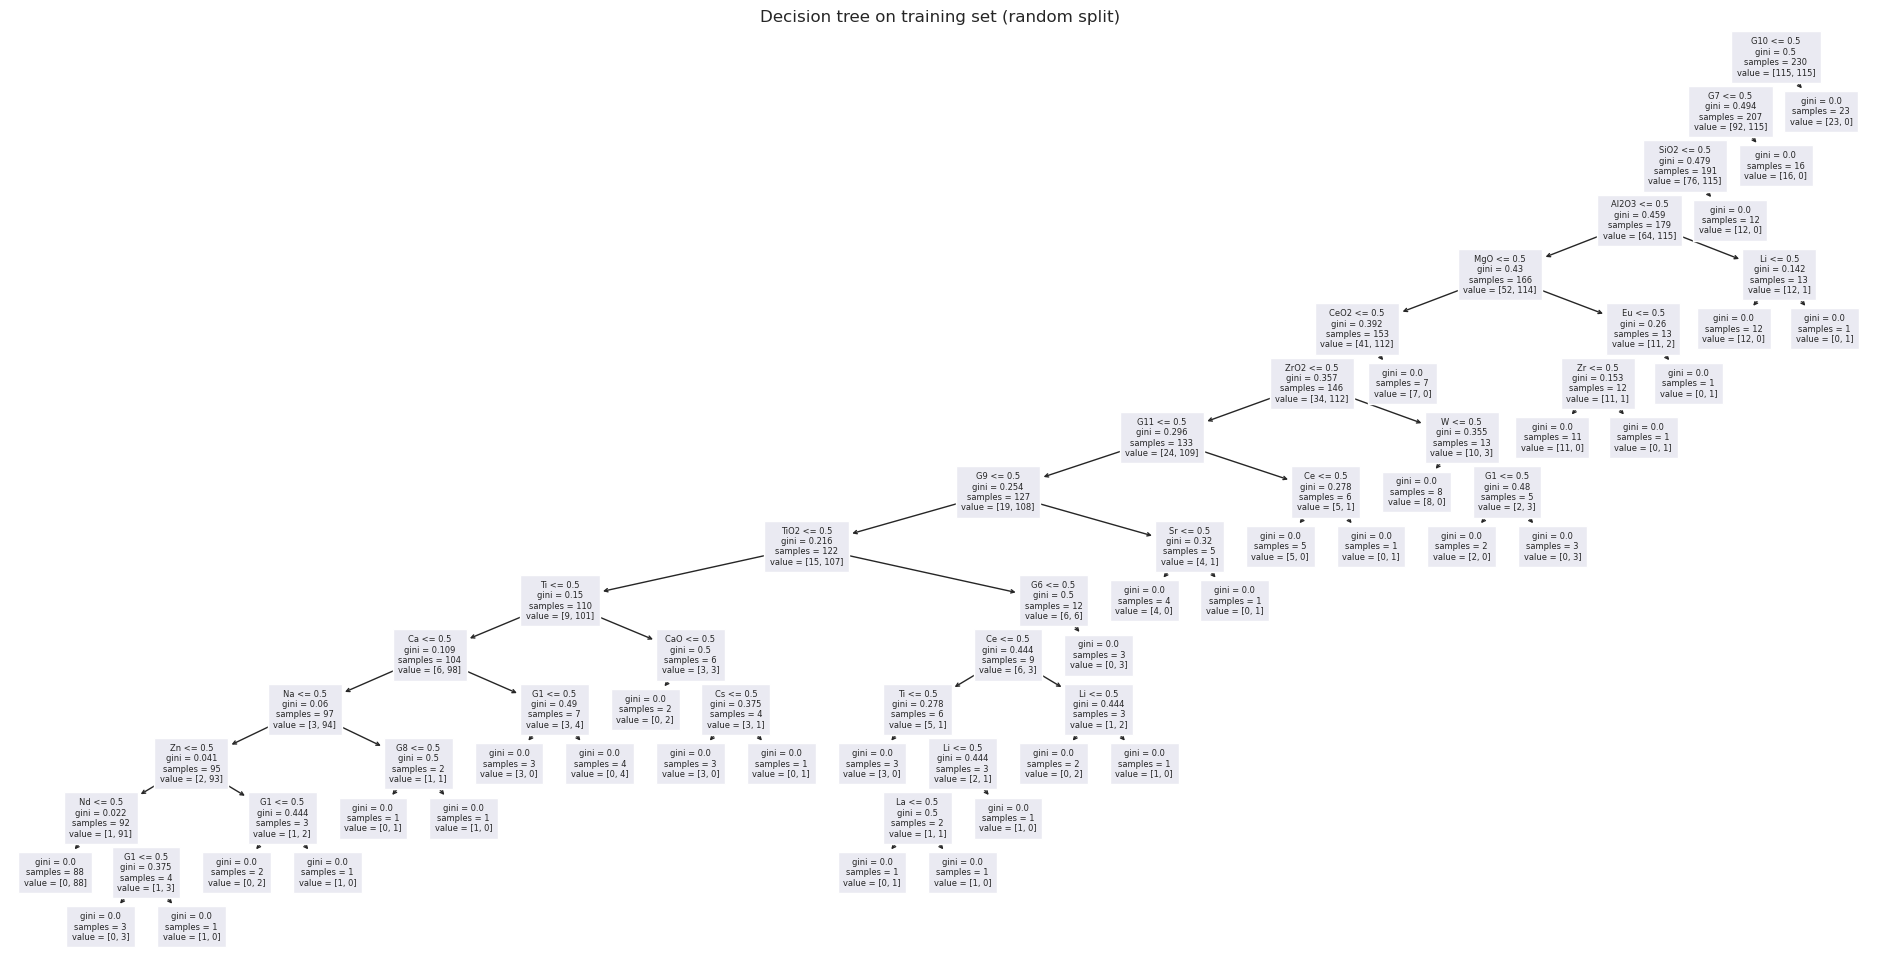

Accuracy scores mean: 0.765593220338983
Accuracy scores standard deviation: 0.048597390940307836
F1 scores mean: 0.4655481045009605
F1 scores mean standard deviation: 0.09897532448041038
precision scores mean: 0.4113100095358643
precision scores standard deviation: 0.09120967067529753
Recall scores mean: 0.5527272727272727
Recall scores standard deviation: 0.14470260182597483


In [173]:
n = 100
acc_tree = []
precision_tree = []
recall_tree = []
f1_tree =[]
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_tree.append(accuracy_score(y_test, y_pred))
    precision_tree.append(precision_score(y_test, y_pred, zero_division =1))
    recall_tree.append(recall_score(y_test, y_pred))
    f1_tree.append(f1_score(y_test, y_pred))
    # print("Iteration %s" % rs)
    # show an example tree
    if (rs == 50):
        plt.figure(figsize=(24,12))
        plot_tree(clf, filled=False, fontsize=6, feature_names=feature_names)
        plt.title("Decision tree on training set (random split)")
        plt.show()
            
            
print(f'Accuracy scores mean: {np.mean(acc_tree)}')
print(f'Accuracy scores standard deviation: {np.std(acc_tree)}')
print(f'F1 scores mean: {np.mean(f1_tree)}')
print(f'F1 scores mean standard deviation: {np.std(f1_tree)}')
print(f'precision scores mean: {np.mean(precision_tree)}')
print(f'precision scores standard deviation: {np.std(precision_tree)}')
print(f'Recall scores mean: {np.mean(recall_tree)}')
print(f'Recall scores standard deviation: {np.std(recall_tree)}')

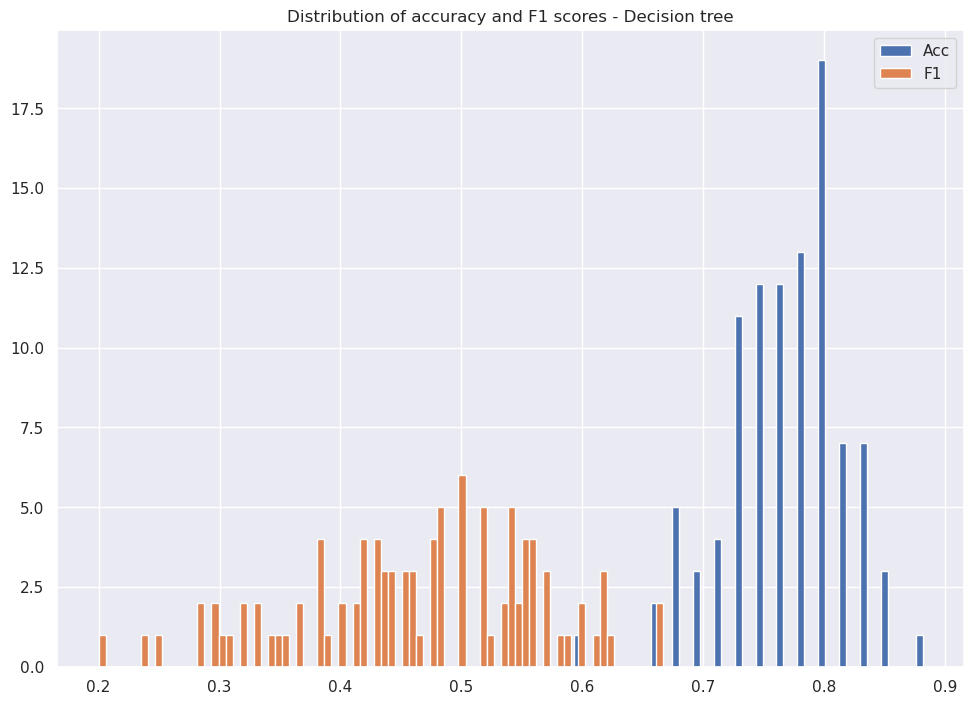

In [174]:
plt.hist(np.array(acc_tree), bins = 50)
plt.hist(np.array(f1_tree), bins = 80)
plt.title('Distribution of accuracy and F1 scores - Decision tree')
plt.legend(['Acc','F1'])
plt.show()

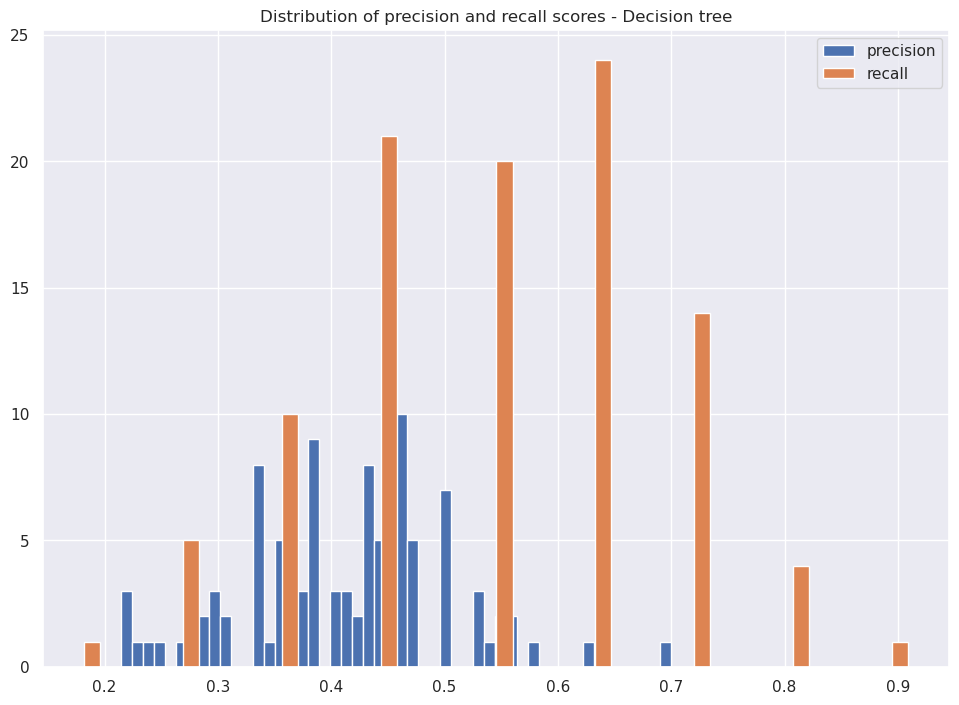

In [175]:
plt.hist(np.array(precision_tree), bins = 50)
plt.hist(np.array(recall_tree), bins = 50)
plt.title('Distribution of precision and recall scores - Decision tree')
plt.legend(['precision','recall'])
plt.show()

### Decision tree with pre-pruning

/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 2
Split 3


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 4


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 5


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 6
Split 7


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 8


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 9


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 10


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 11


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 12


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 13


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 14


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 15
Split 16


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 17


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 18


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 19


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 20
Split 21


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 22


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 23


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 24


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 25


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 26


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 27
Split 28


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 29


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 30


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 31


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 32


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 33


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 34
Split 35


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 36


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 37


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 38


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 39
Split 40
Split 41


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 42


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 43


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 44


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 45


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 46


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 47


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 48


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 49


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 50


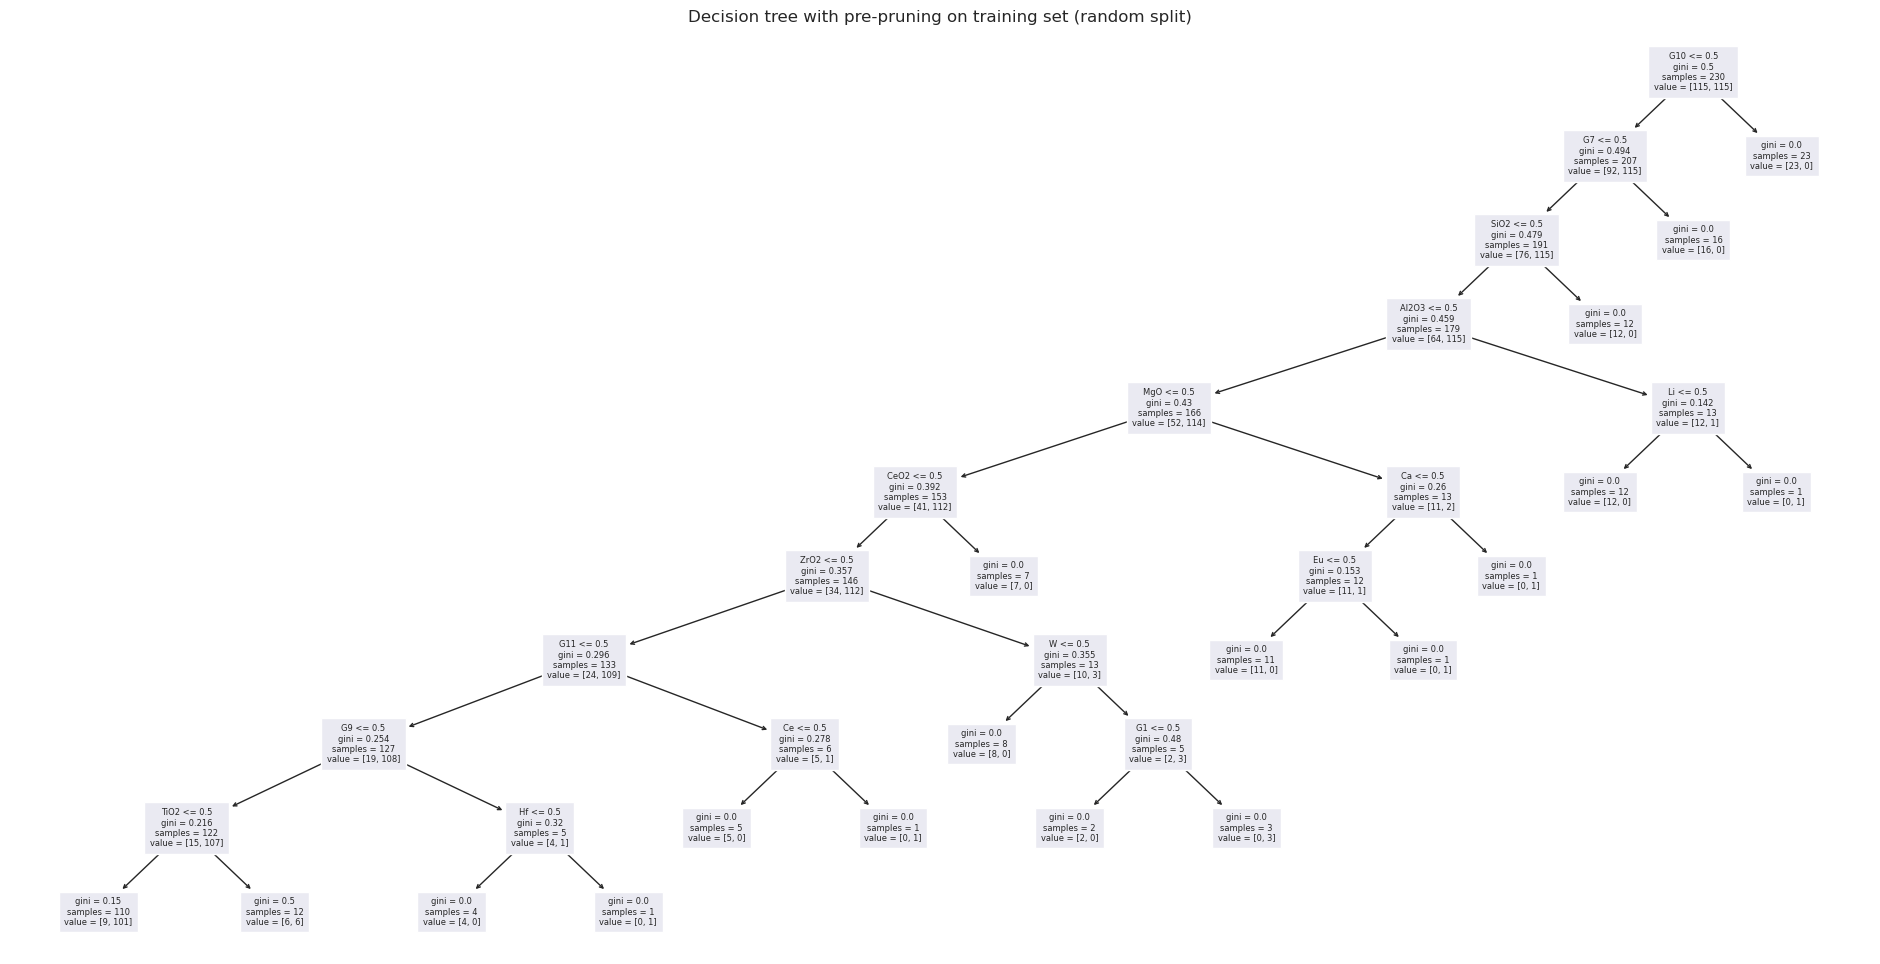

/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 51


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 52


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 53


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 54


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 55


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 56
Split 57


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 58


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 59


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 60


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 61


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 62


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 63


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 64


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 65


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 66


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 67


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 68


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 69


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 70


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 71
Split 72


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 73


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 74


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 75


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 76


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 77


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 78


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 79


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 80


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 81


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 82


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 83


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 84


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 85


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 86


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 87


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 88


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 89


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 90
Split 91


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 92


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 93


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 94


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 95


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 96


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 97


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 98


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [ ]:
n = 100
acc_preprun = []
precision_preprun = []
recall_preprun = []
f1_preprun = []
max_depth_preprun = []
min_samples_split_preprun = []
min_samples_leaf_preprun = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_preprun = DecisionTreeClassifier(random_state = 0)
    space = [Integer(1, 10, name='max_depth'),
          Integer(2, 20, name='min_samples_split'),
          Integer(1, 20, name='min_samples_leaf')]
    @use_named_args(space)
    def objective(**params):
        clf_preprun.set_params(**params)
        return -np.mean(cross_val_score(clf_preprun, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_preprun_optim = DecisionTreeClassifier(random_state = 0, max_depth = res_gp.x[0], 
                                              min_samples_split = res_gp.x[1], min_samples_leaf = res_gp.x[2])
    max_depth_preprun.append(res_gp.x[0])
    min_samples_split_preprun.append(res_gp.x[1])
    min_samples_leaf_preprun.append(res_gp.x[2])
        
    clf_preprun_optim.fit(X_train, y_train)
    y_pred = clf_preprun_optim.predict(X_test)
    acc_preprun.append(accuracy_score(y_test, y_pred))
    precision_preprun.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_preprun.append(recall_score(y_test, y_pred))
    f1_preprun.append(np.abs(res_gp.fun))
    print("Split %s" % rs)
    # show an example tree
    if (rs == 50):
        plt.figure(figsize=(24,12))
        plot_tree(clf_preprun_optim, filled=False, fontsize=6, feature_names=feature_names)
        plt.title("Decision tree with pre-pruning on training set (random split)")
        plt.show()
            
            
print(f'Accuracy scores mean: {np.mean(acc_preprun)}')
print(f'Accuracy scores standard deviation: {np.std(acc_preprun)}')
print(f'F1 scores mean: {np.mean(f1_preprun)}')
print(f'F1 scores mean standard deviation: {np.std(f1_preprun)}')
print(f'precision scores mean: {np.mean(precision_preprun)}')
print(f'precision scores standard deviation: {np.std(precision_preprun)}')
print(f'Recall scores mean: {np.mean(recall_preprun)}')
print(f'Recall scores standard deviation: {np.std(recall_preprun)}')

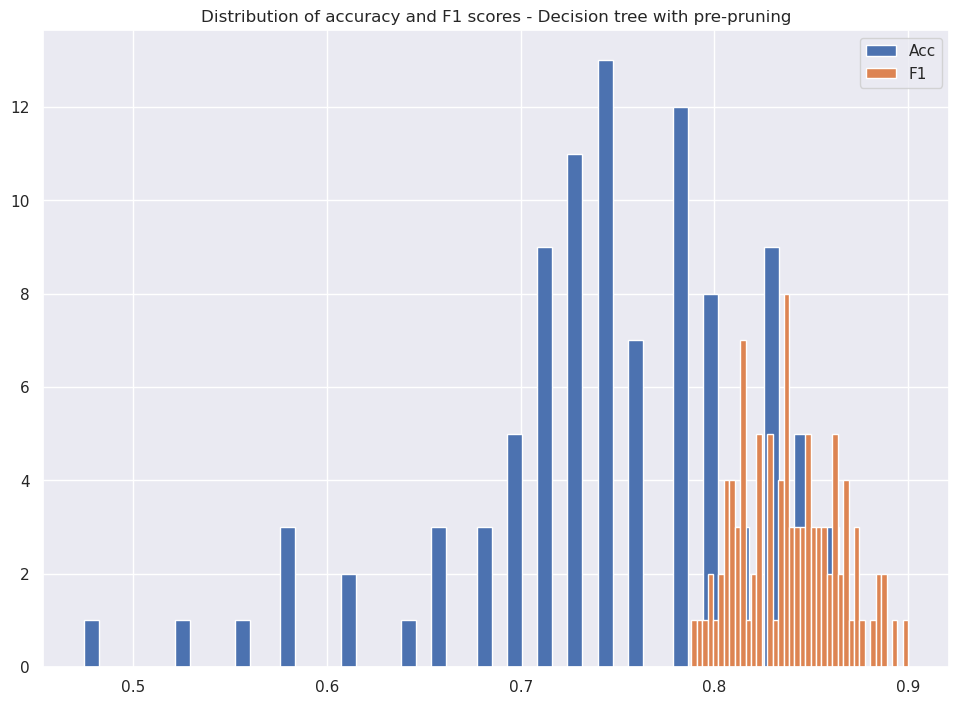

In [178]:
plt.hist(np.array(acc_preprun), bins = 50)
plt.hist(np.array(f1_preprun), bins = 40)
plt.title('Distribution of accuracy and F1 scores - Decision tree with pre-pruning')
plt.legend(['Acc','F1'])
plt.show()

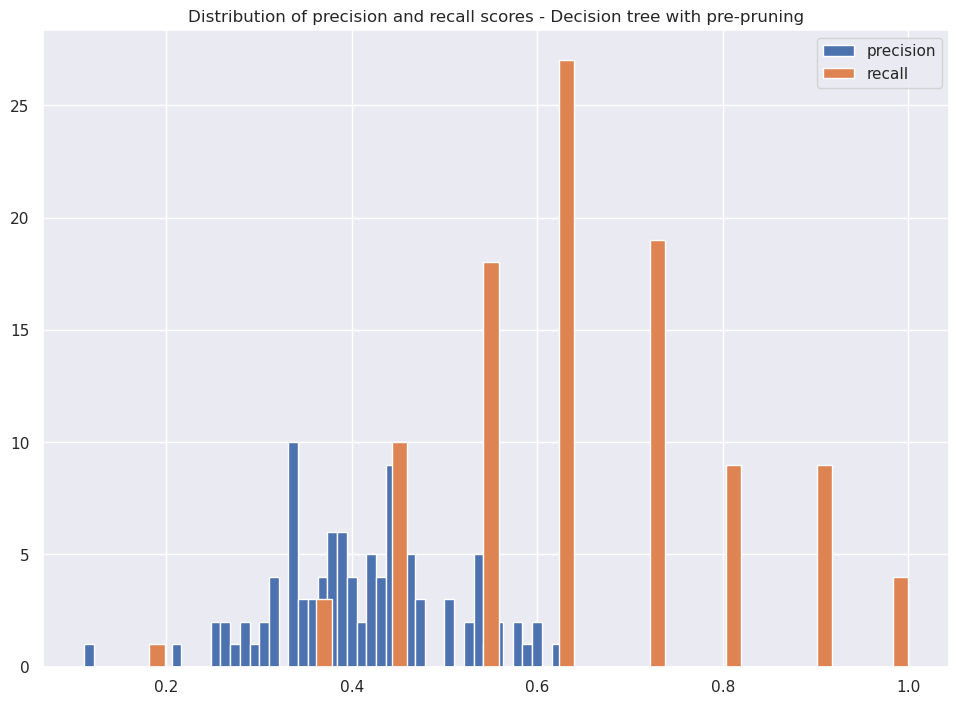

In [179]:
plt.hist(np.array(precision_preprun), bins = 50)
plt.hist(np.array(recall_preprun), bins = 50)
plt.title('Distribution of precision and recall scores - Decision tree with pre-pruning')
plt.legend(['precision','recall'])
plt.show()

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
        14.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  0.,  0.,  0.,  0.,
        45.]),
 array([ 4.  ,  4.15,  4.3 ,  4.45,  4.6 ,  4.75,  4.9 ,  5.05,  5.2 ,
         5.35,  5.5 ,  5.65,  5.8 ,  5.95,  6.1 ,  6.25,  6.4 ,  6.55,
         6.7 ,  6.85,  7.  ,  7.15,  7.3 ,  7.45,  7.6 ,  7.75,  7.9 ,
         8.05,  8.2 ,  8.35,  8.5 ,  8.65,  8.8 ,  8.95,  9.1 ,  9.25,
         9.4 ,  9.55,  9.7 ,  9.85, 10.  ]),
 <BarContainer object of 40 artists>)

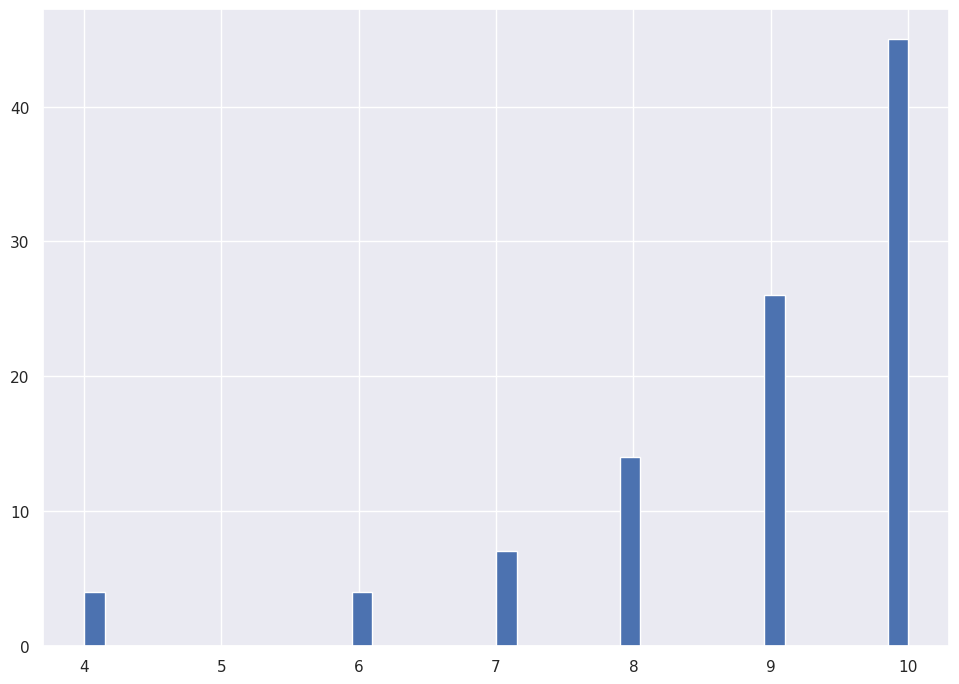

In [180]:
plt.hist(max_depth_preprun, bins=40)

(array([48.,  0.,  7.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         2.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        32.]),
 array([ 2.  ,  2.45,  2.9 ,  3.35,  3.8 ,  4.25,  4.7 ,  5.15,  5.6 ,
         6.05,  6.5 ,  6.95,  7.4 ,  7.85,  8.3 ,  8.75,  9.2 ,  9.65,
        10.1 , 10.55, 11.  , 11.45, 11.9 , 12.35, 12.8 , 13.25, 13.7 ,
        14.15, 14.6 , 15.05, 15.5 , 15.95, 16.4 , 16.85, 17.3 , 17.75,
        18.2 , 18.65, 19.1 , 19.55, 20.  ]),
 <BarContainer object of 40 artists>)

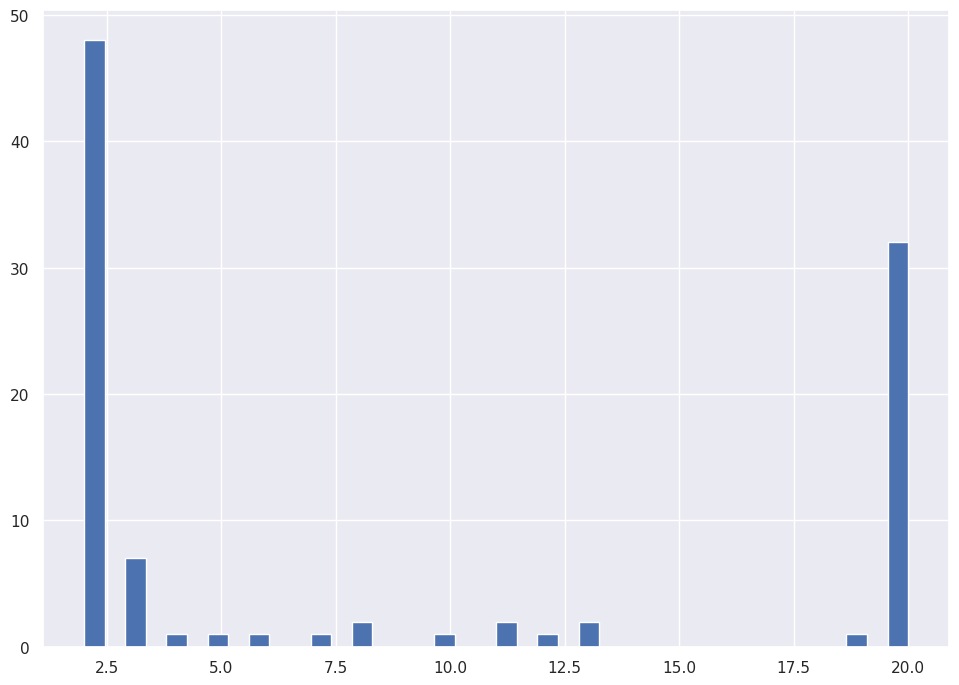

In [181]:
plt.hist(min_samples_split_preprun, bins=40)

(array([49.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  0.,  0., 20.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([1.   , 1.175, 1.35 , 1.525, 1.7  , 1.875, 2.05 , 2.225, 2.4  ,
        2.575, 2.75 , 2.925, 3.1  , 3.275, 3.45 , 3.625, 3.8  , 3.975,
        4.15 , 4.325, 4.5  , 4.675, 4.85 , 5.025, 5.2  , 5.375, 5.55 ,
        5.725, 5.9  , 6.075, 6.25 , 6.425, 6.6  , 6.775, 6.95 , 7.125,
        7.3  , 7.475, 7.65 , 7.825, 8.   ]),
 <BarContainer object of 40 artists>)

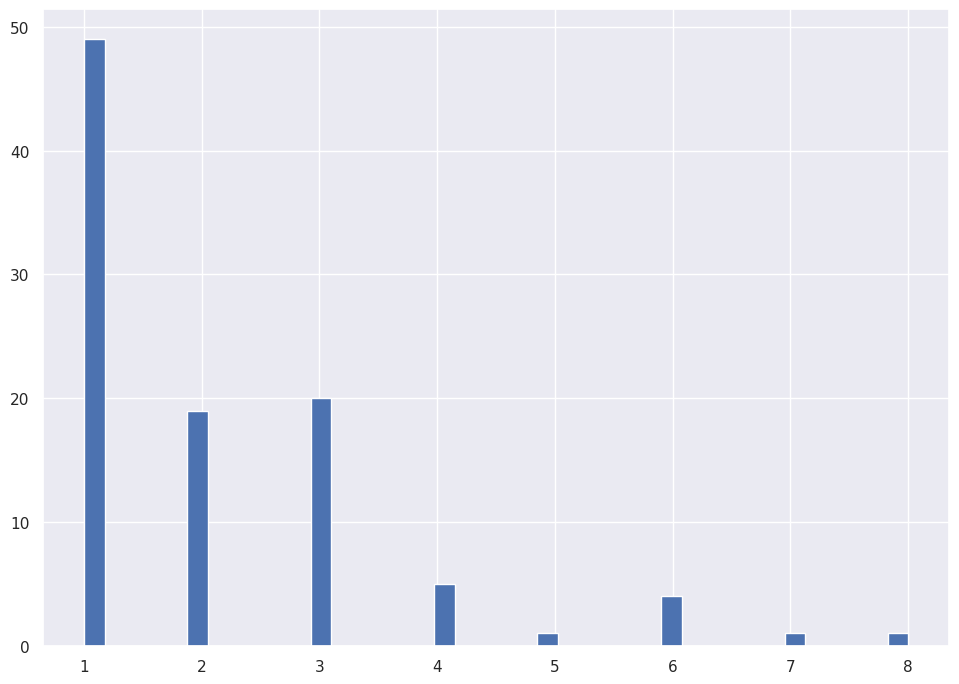

In [182]:
plt.hist(min_samples_leaf_preprun, bins=40)

### Decision tree with post-pruning

Iteration 0
Iteration 1


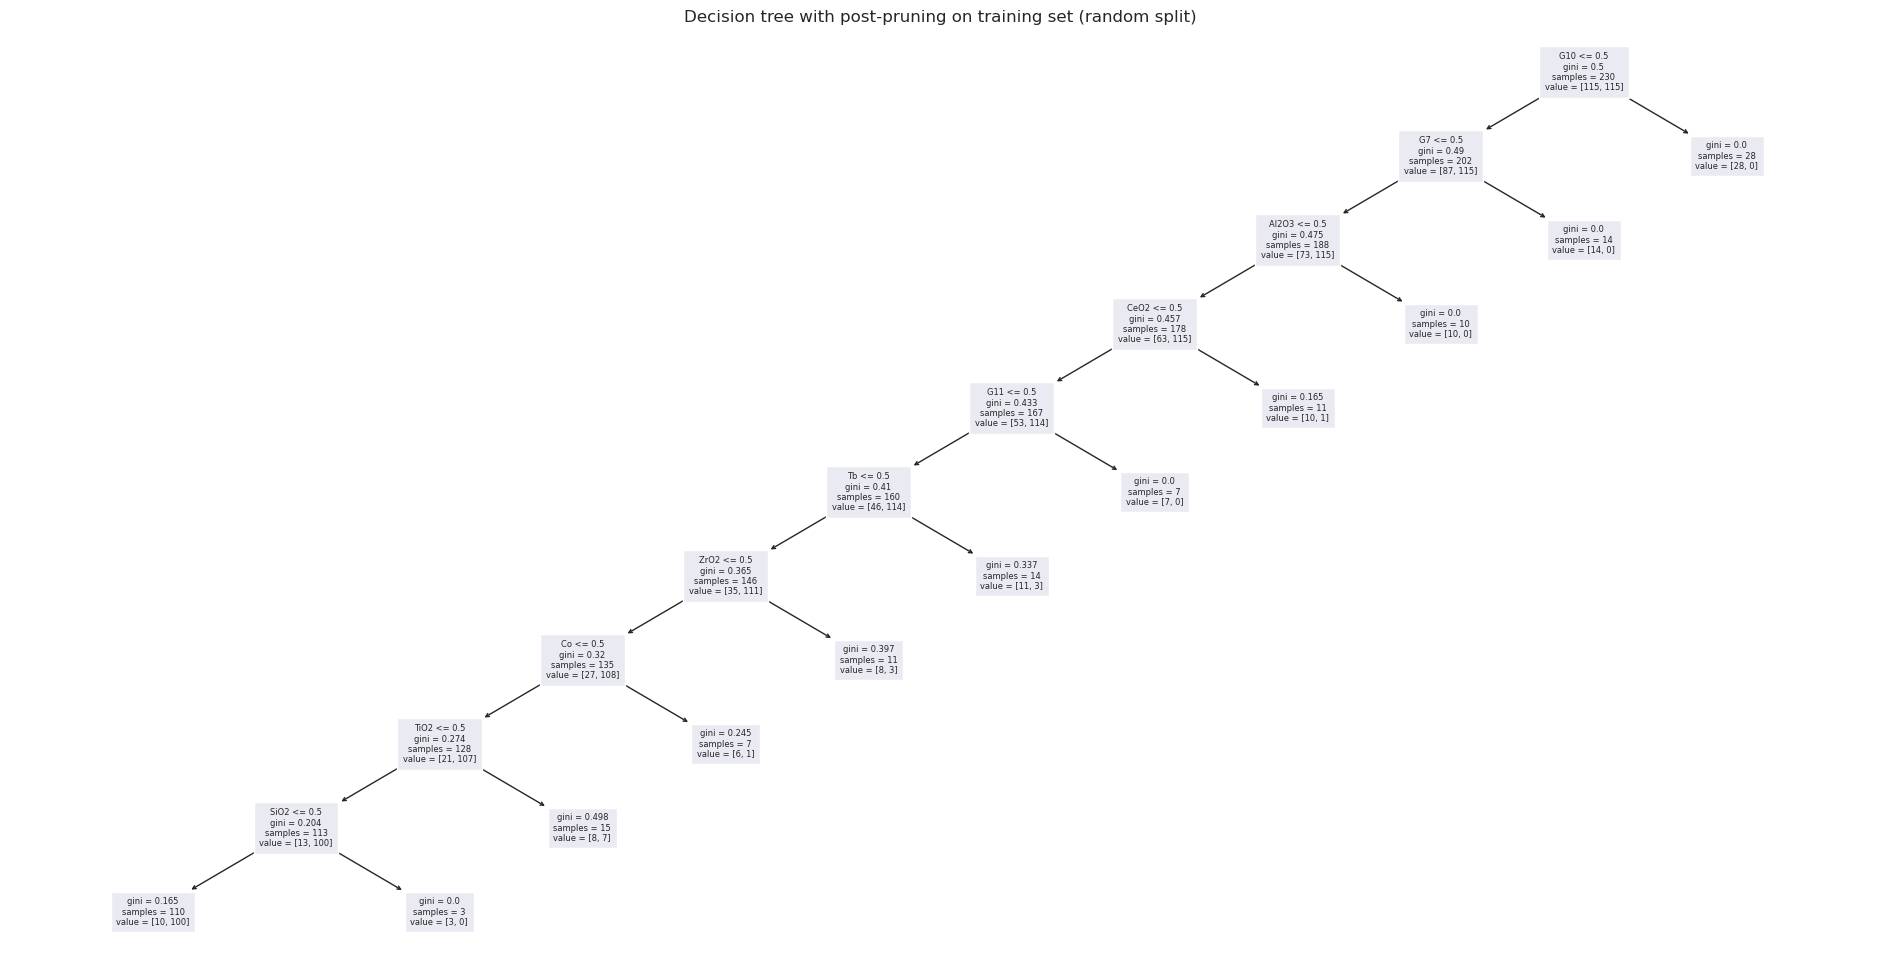

Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iterati

In [183]:
n = 100
acc_postprun = []
precision_postprun = []
recall_postprun = []
f1_postprun =[]
alpha_postprun =[]
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
        
    clf = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs_ = []
    for ccp_alpha in ccp_alphas:
        clf_ = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
        clf_.fit(X_train, y_train)
        clfs_.append(clf_)
        
    clfs_ = clfs_[:-1]
    ccp_alphas = ccp_alphas[:-1]
        
    train_acc = []
    test_acc = []
    for c in clfs_:
        y_train_pred = c.predict(X_train)
        y_test_pred = c.predict(X_test)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))

    alpha = ccp_alphas[np.argmax(test_acc)]
    alpha_postprun.append(alpha)
    clf_postprun = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha=alpha)
    clf_postprun.fit(X_train, y_train)
    y_pred_postprun = clf_postprun.predict(X_test)

    acc_postprun.append(accuracy_score(y_test, y_pred_postprun))
    precision_postprun.append(precision_score(y_test, y_pred_postprun, zero_division =1))
    recall_postprun.append(recall_score(y_test, y_pred_postprun))
    f1_postprun.append(f1_score(y_test, y_pred_postprun))
    print("Iteration %s" % rs)
    # show an example tree
    if (rs == 1):
        plt.figure(figsize=(24,12))
        plot_tree(clf_postprun, filled=False, fontsize=6, feature_names=feature_names)
        plt.title("Decision tree with post-pruning on training set (random split)")
        plt.show()
            
            
print(f'Accuracy scores mean: {np.mean(acc_postprun)}')
print(f'Accuracy scores standard deviation: {np.std(acc_postprun)}')
print(f'F1 scores mean: {np.mean(f1_postprun)}')
print(f'F1 scores mean standard deviation: {np.std(f1_postprun)}')
print(f'precision scores mean: {np.mean(precision_postprun)}')
print(f'precision scores standard deviation: {np.std(precision_postprun)}')
print(f'Recall scores mean: {np.mean(recall_postprun)}')
print(f'Recall scores standard deviation: {np.std(recall_postprun)}')

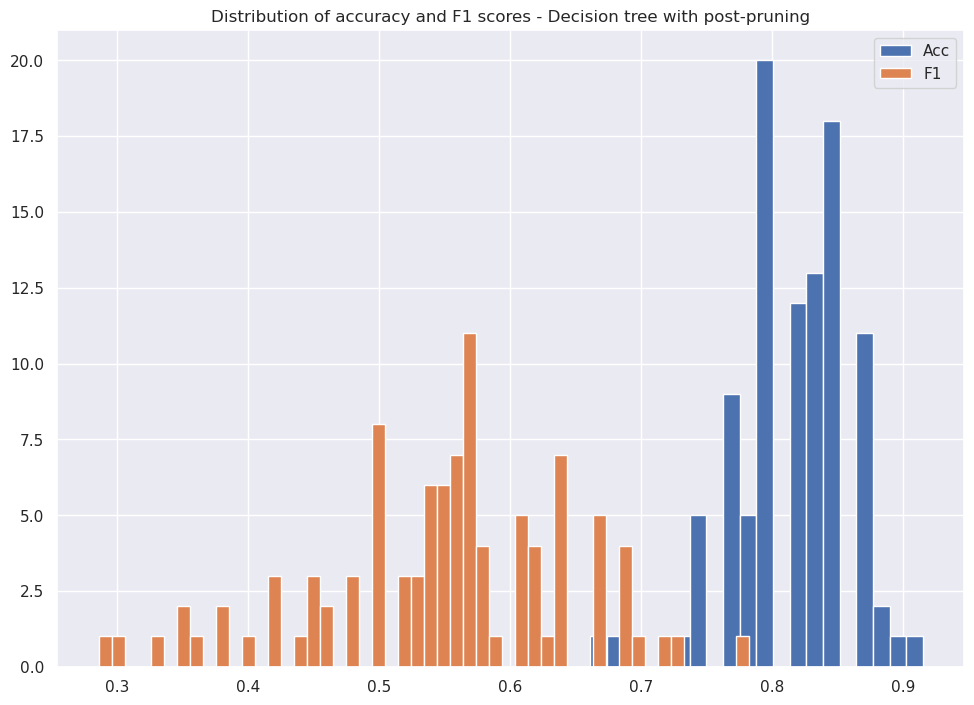

In [184]:
plt.hist(np.array(acc_postprun), bins = 20)
plt.hist(np.array(f1_postprun), bins = 50)
plt.title('Distribution of accuracy and F1 scores - Decision tree with post-pruning')
plt.legend(['Acc','F1'])
plt.show()

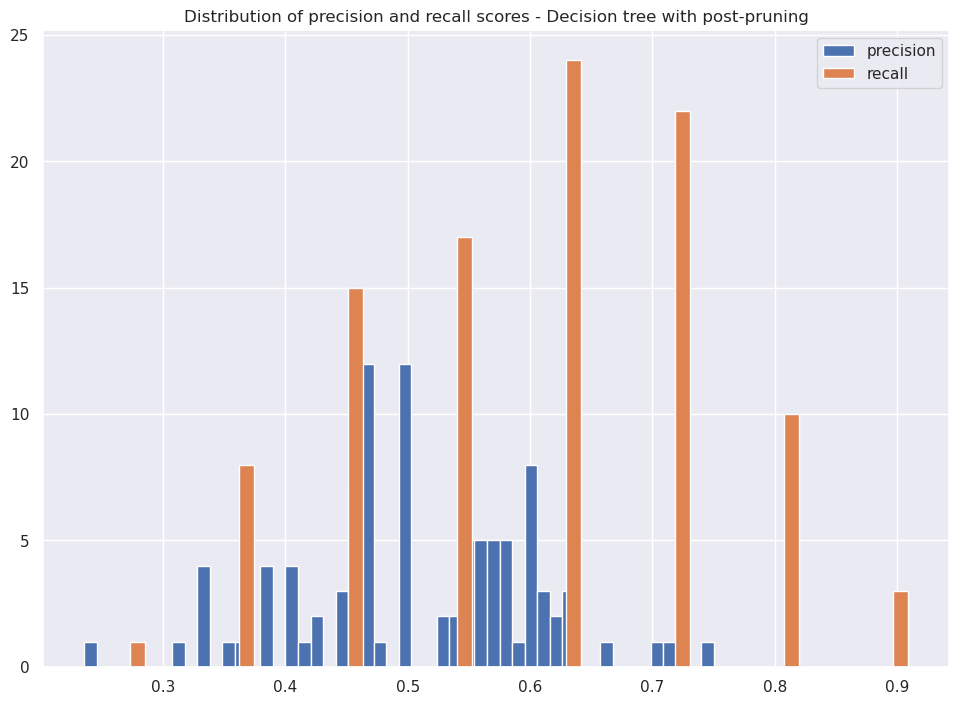

In [185]:
plt.hist(np.array(precision_postprun), bins = 50)
plt.hist(np.array(recall_postprun), bins = 50)
plt.title('Distribution of precision and recall scores - Decision tree with post-pruning')
plt.legend(['precision','recall'])
plt.show()

(array([17.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  4.,  8.,  0.,
         1.,  4.,  3.,  1.,  4.,  3.,  2.,  7.,  6.,  6.,  2.,  2.,  1.,
         6.,  0.,  0.,  4.,  0.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,
         1.,  2.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.00036997, 0.00073994, 0.00110991, 0.00147989,
        0.00184986, 0.00221983, 0.0025898 , 0.00295977, 0.00332974,
        0.00369971, 0.00406969, 0.00443966, 0.00480963, 0.0051796 ,
        0.00554957, 0.00591954, 0.00628951, 0.00665949, 0.00702946,
        0.00739943, 0.0077694 , 0.00813937, 0.00850934, 0.00887931,
        0.00924929, 0.00961926, 0.00998923, 0.0103592 , 0.01072917,
        0.01109914, 0.01146911, 0.01183909, 0.01220906, 0.01257903,
        0.012949  , 0.01331897, 0.01368894, 0.01405891, 0.01442889,
        0.01479886, 0.01516883, 0.0155388 , 0.01590877, 0.01627874,
        0.01664871, 0.01701869, 0.01738866, 0.

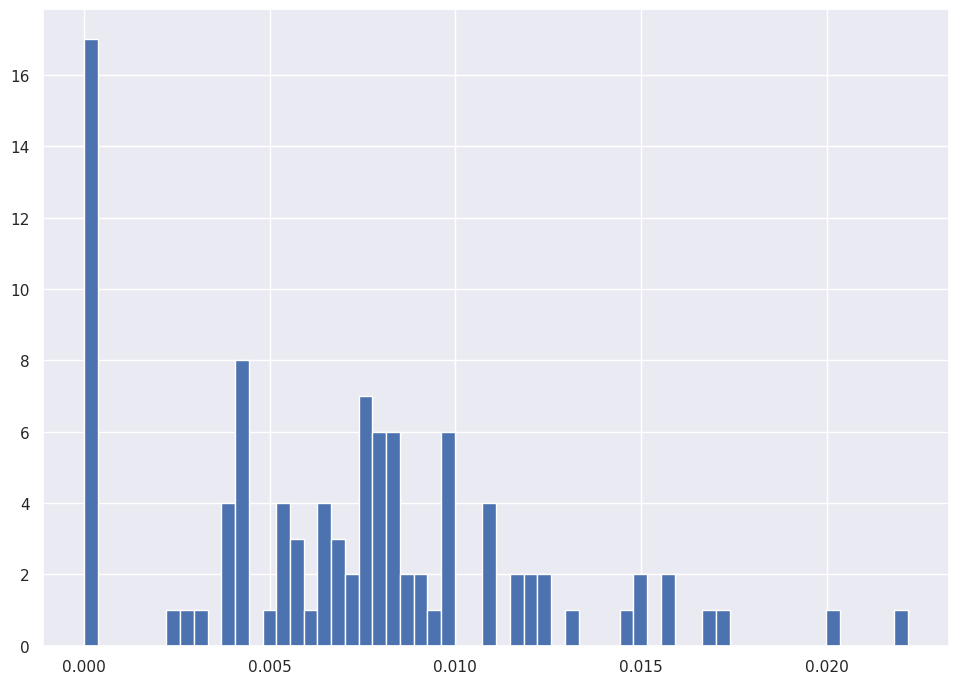

In [186]:
plt.hist(alpha_postprun, bins=60)

### Random forest

In [125]:
from sklearn.ensemble import RandomForestClassifier
n = 100
acc_forest = []
precision_forest = []
recall_forest = []
f1_forest =[]
max_depth_rf =[]
n_estimators_rf =[]
min_samples_split_rf =[]
min_samples_leaf_rf =[]

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_forest = RandomForestClassifier(random_state = 0)
    space = [Integer(1, 10, name='max_depth'),
          Integer(50, 500, name='n_estimators'),
          Integer(2, 20, name='min_samples_split'),
          Integer(1, 20, name='min_samples_leaf')]
    @use_named_args(space)
    def objective(**params):
        clf_forest.set_params(**params)
        return -np.mean(cross_val_score(clf_forest, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_forest_optim = RandomForestClassifier(random_state = 0, max_depth = res_gp.x[0], n_estimators = res_gp.x[1], 
                                              min_samples_split = res_gp.x[2], min_samples_leaf = res_gp.x[3])
    max_depth_rf.append(res_gp.x[0])
    n_estimators_rf.append(res_gp.x[1])
    min_samples_split_rf.append(res_gp.x[2])
    min_samples_leaf_rf.append(res_gp.x[3])
        
    clf_forest_optim.fit(X_train, y_train)
    y_pred = clf_forest_optim.predict(X_test)
    acc_forest.append(accuracy_score(y_test, y_pred))
    precision_forest.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_forest.append(recall_score(y_test, y_pred))
    f1_forest.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_forest)}')
print(f'Accuracy scores standard deviation: {np.std(acc_forest)}')
print(f'F1 scores mean: {np.mean(f1_forest)}')
print(f'F1 scores mean standard deviation: {np.std(f1_forest)}')
print(f'precision scores mean: {np.mean(precision_forest)}')
print(f'precision scores standard deviation: {np.std(precision_forest)}')
print(f'Recall scores mean: {np.mean(recall_forest)}')
print(f'Recall scores standard deviation: {np.std(recall_forest)}')

/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 2


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 3


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 4
Split 5


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 6


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 7


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 8


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 9


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 10


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 11
Split 12


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 13


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 14


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 15


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 16


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 17


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 18


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 19
Split 20
Split 21


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 22


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 23


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 24


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 25
Split 26


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 27


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 28


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 29


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 30
Split 31


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 32


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 33


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 34


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 35


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 36


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 37


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 38


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 39


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 40
Split 41


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 42


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 43


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 44


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 45


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 46


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 47
Split 48


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 49


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 50


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 51
Split 52


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 53


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 54


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 55


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 56


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 57


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 58
Split 59


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 60
Split 61


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 62


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 63
Split 64
Split 65


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 66
Split 67


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 68


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 69
Split 70
Split 71


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 72


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 73


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 74
Split 75
Split 76
Split 77
Split 78


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 79


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 80


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 81
Split 82
Split 83


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 84


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 85


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 86


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 87


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 88


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 89


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 90
Split 91


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 92


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 93


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 94


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 95
Split 96


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 97


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 98
Split 99
Accuracy scores mean: 0.7737288135593219
Accuracy scores standard deviation: 0.05170880613592136
F1 scores mean: 0.8568820232164164
F1 scores mean standard deviation: 0.019607634795364974
precision scores mean: 0.43663163242614056
precision scores standard deviation: 0.08609690602222317
Recall scores mean: 0.6563636363636364
Recall scores standard deviation: 0.1457837184392807


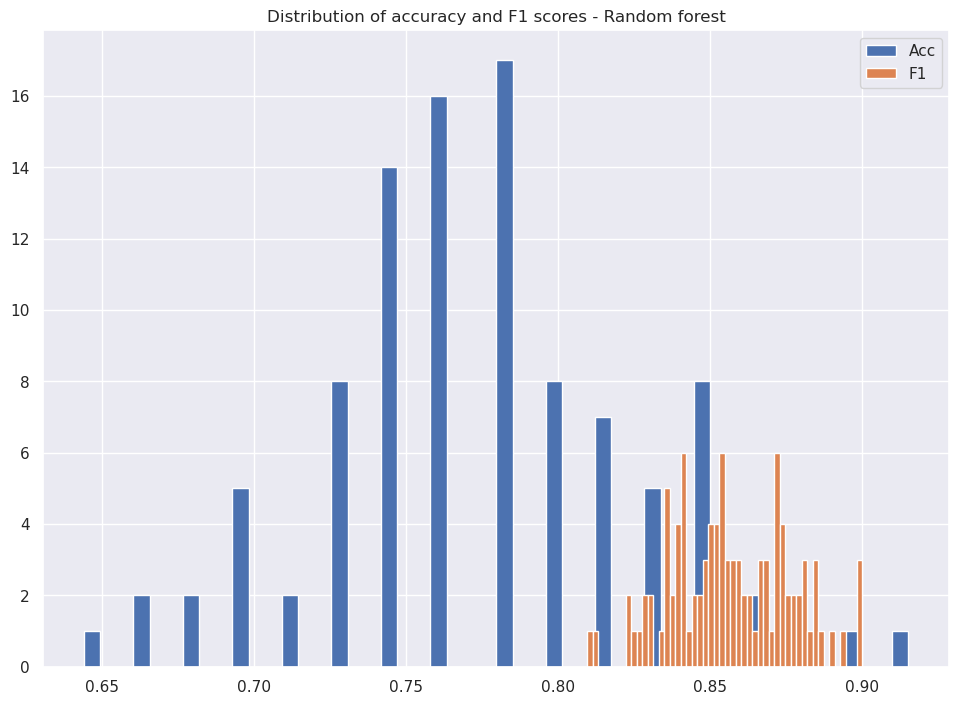

In [187]:
plt.hist(np.array(acc_forest), bins = 50)
plt.hist(np.array(f1_forest), bins = 50)
plt.title('Distribution of accuracy and F1 scores - Random forest')
plt.legend(['Acc','F1'])
plt.show()

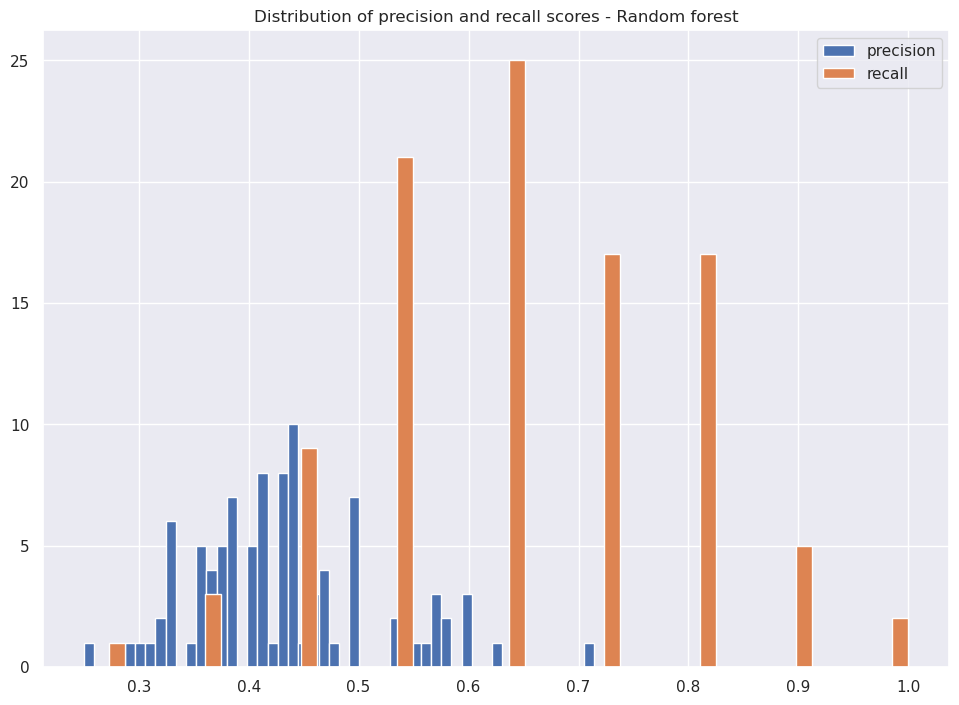

In [188]:
plt.hist(np.array(precision_forest), bins = 50)
plt.hist(np.array(recall_forest), bins = 50)
plt.title('Distribution of precision and recall scores - Random forest')
plt.legend(['precision','recall'])
plt.show()

(array([ 1.,  2.,  0.,  2.,  0., 11.,  2.,  0.,  4., 78.]),
 array([ 4. ,  4.6,  5.2,  5.8,  6.4,  7. ,  7.6,  8.2,  8.8,  9.4, 10. ]),
 <BarContainer object of 10 artists>)

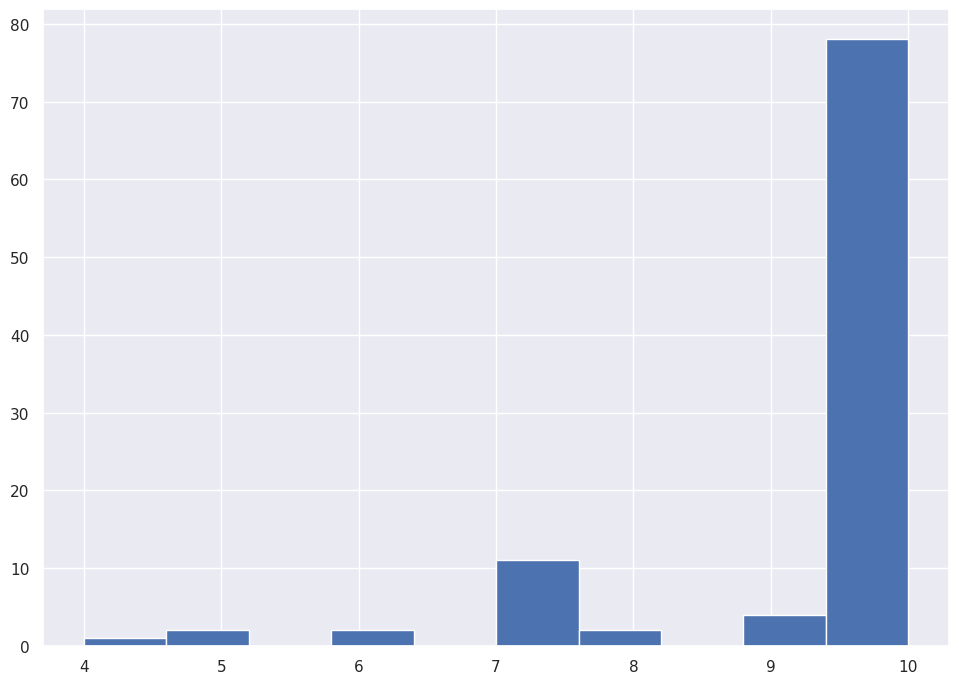

In [189]:
plt.hist(max_depth_rf)

(array([29.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,
         0.,  1.,  6.,  0.,  0.,  1.,  0.,  2.,  2.,  0.,  1.,  0.,  2.,
         0.,  3.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  4.,  1.,
        38.]),
 array([ 50.  ,  61.25,  72.5 ,  83.75,  95.  , 106.25, 117.5 , 128.75,
        140.  , 151.25, 162.5 , 173.75, 185.  , 196.25, 207.5 , 218.75,
        230.  , 241.25, 252.5 , 263.75, 275.  , 286.25, 297.5 , 308.75,
        320.  , 331.25, 342.5 , 353.75, 365.  , 376.25, 387.5 , 398.75,
        410.  , 421.25, 432.5 , 443.75, 455.  , 466.25, 477.5 , 488.75,
        500.  ]),
 <BarContainer object of 40 artists>)

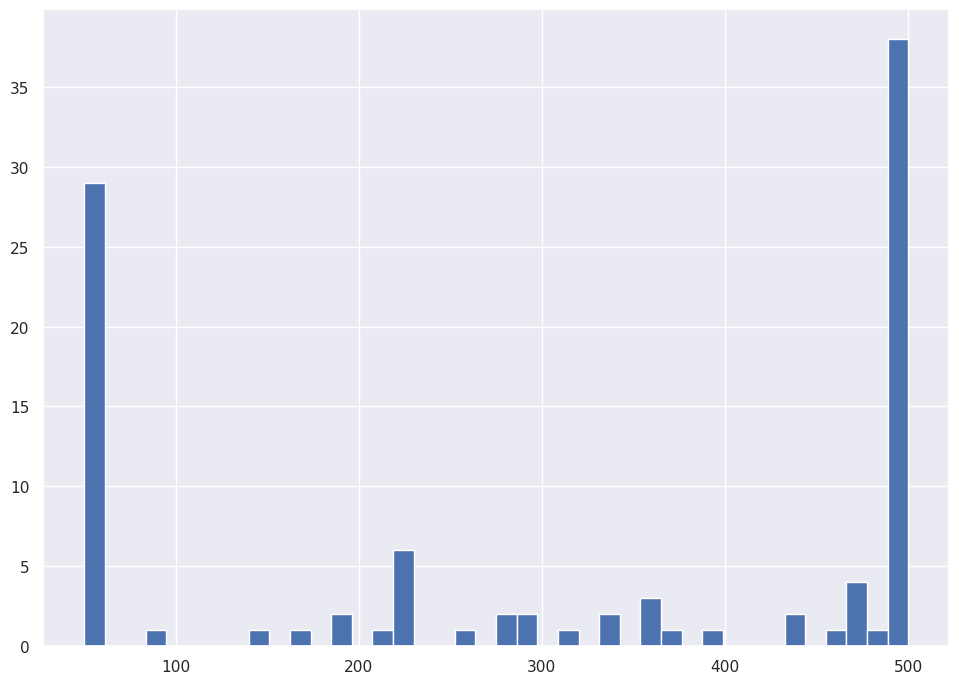

In [190]:
plt.hist(n_estimators_rf,bins=40)

(array([49.,  0.,  4.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  6.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        29.]),
 array([ 2.  ,  2.45,  2.9 ,  3.35,  3.8 ,  4.25,  4.7 ,  5.15,  5.6 ,
         6.05,  6.5 ,  6.95,  7.4 ,  7.85,  8.3 ,  8.75,  9.2 ,  9.65,
        10.1 , 10.55, 11.  , 11.45, 11.9 , 12.35, 12.8 , 13.25, 13.7 ,
        14.15, 14.6 , 15.05, 15.5 , 15.95, 16.4 , 16.85, 17.3 , 17.75,
        18.2 , 18.65, 19.1 , 19.55, 20.  ]),
 <BarContainer object of 40 artists>)

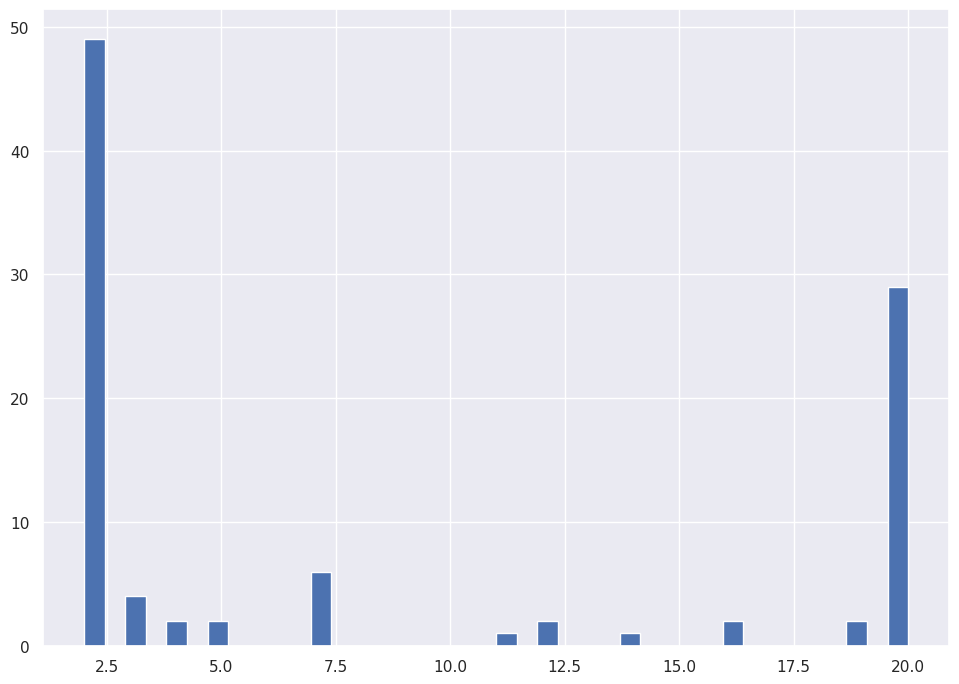

In [191]:
plt.hist(min_samples_split_rf,bins=40)

(array([62.,  0., 26.,  0.,  0.,  6.,  0.,  4.,  0.,  2.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

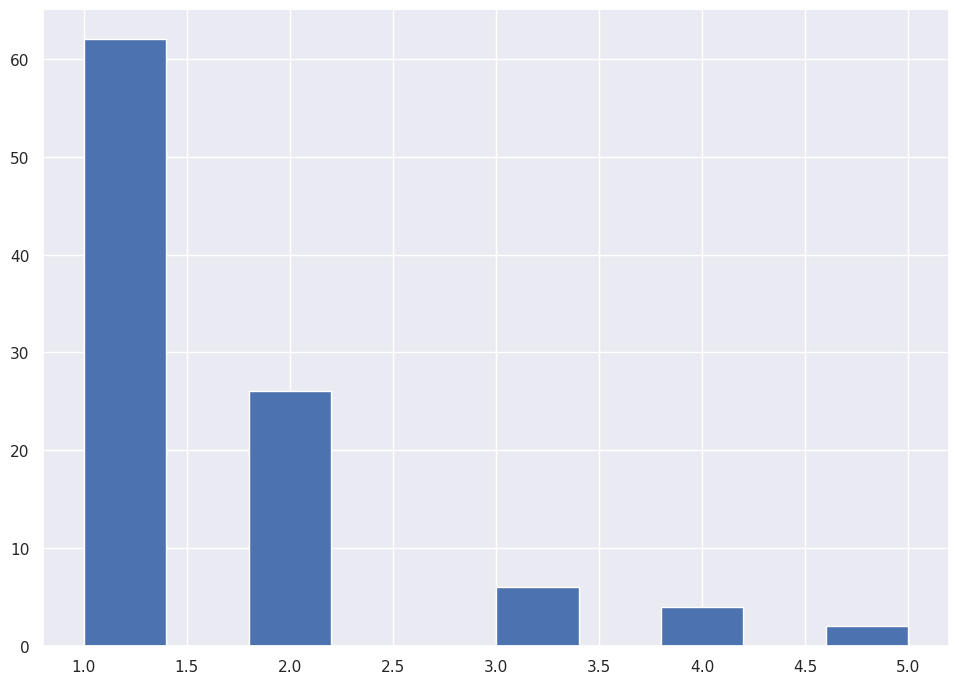

In [192]:
plt.hist(min_samples_leaf_rf)

### Gradient boosting tree

In [129]:
from sklearn.ensemble import GradientBoostingClassifier
n = 100
acc_GBT = []
precision_GBT = []
recall_GBT = []
f1_GBT =[]
learning_rate_GBT =[]
n_estimators_GBT = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_GBT = GradientBoostingClassifier(random_state = 0)
    space = [Integer(1, 10, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Integer(1, 49, name='max_features'),
             Integer(50, 500, name='n_estimators'),
             Integer(2, 20, name='min_samples_split'),
             Integer(1, 20, name='min_samples_leaf')]
    @use_named_args(space)
    def objective(**params):
        clf_GBT.set_params(**params)
        return -np.mean(cross_val_score(clf_GBT, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_GBT_optim = GradientBoostingClassifier(random_state = 0, max_depth = res_gp.x[0], learning_rate = res_gp.x[1],
                                               max_features = res_gp.x[2], n_estimators = res_gp.x[3], 
                                               min_samples_split = res_gp.x[4], min_samples_leaf = res_gp.x[5])
    learning_rate_GBT.append(res_gp.x[1])
    n_estimators_GBT.append(res_gp.x[3])
        
    clf_GBT_optim.fit(X_train, y_train)
    y_pred = clf_GBT_optim.predict(X_test)
    acc_GBT.append(accuracy_score(y_test, y_pred))
    precision_GBT.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_GBT.append(recall_score(y_test, y_pred))
    f1_GBT.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_GBT)}')
print(f'Accuracy scores standard deviation: {np.std(acc_GBT)}')
print(f'F1 scores mean: {np.mean(f1_GBT)}')
print(f'F1 scores mean standard deviation: {np.std(f1_GBT)}')
print(f'precision scores mean: {np.mean(precision_GBT)}')
print(f'precision scores standard deviation: {np.std(precision_GBT)}')
print(f'Recall scores mean: {np.mean(recall_GBT)}')
print(f'Recall scores standard deviation: {np.std(recall_GBT)}')

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30
Split 31
Split 32
Split 33
Split 34
Split 35
Split 36
Split 37
Split 38
Split 39
Split 40
Split 41
Split 42
Split 43
Split 44
Split 45
Split 46
Split 47
Split 48
Split 49
Split 50
Split 51
Split 52
Split 53
Split 54
Split 55
Split 56
Split 57
Split 58
Split 59
Split 60
Split 61
Split 62
Split 63
Split 64
Split 65
Split 66
Split 67
Split 68
Split 69
Split 70


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 71
Split 72
Split 73
Split 74
Split 75
Split 76
Split 77
Split 78
Split 79
Split 80
Split 81
Split 82
Split 83
Split 84
Split 85
Split 86
Split 87
Split 88
Split 89
Split 90
Split 91
Split 92
Split 93
Split 94
Split 95


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 96
Split 97
Split 98
Split 99
Accuracy scores mean: 0.7752542372881357
Accuracy scores standard deviation: 0.052603572887153886
F1 scores mean: 0.8637791152262767
F1 scores mean standard deviation: 0.01901257528341337
precision scores mean: 0.43671365018951086
precision scores standard deviation: 0.09218581830650951
Recall scores mean: 0.6
Recall scores standard deviation: 0.15427784316797402


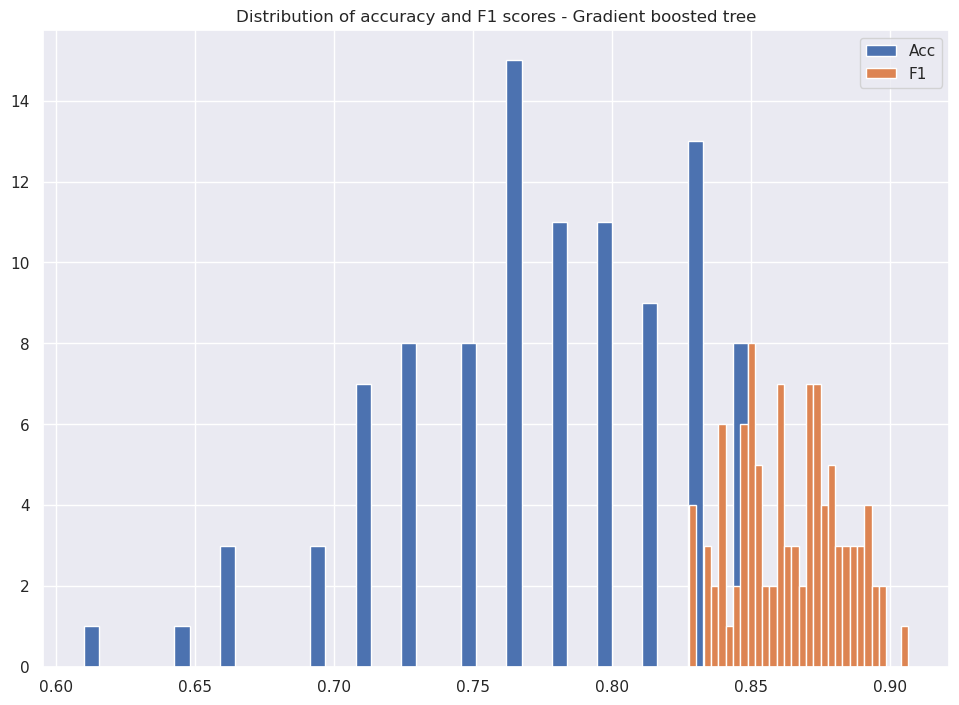

In [195]:
plt.hist(np.array(acc_GBT), bins = 50)
plt.hist(np.array(f1_GBT), bins = 30)
plt.title('Distribution of accuracy and F1 scores - Gradient boosted tree')
plt.legend(['Acc','F1'])
plt.show()

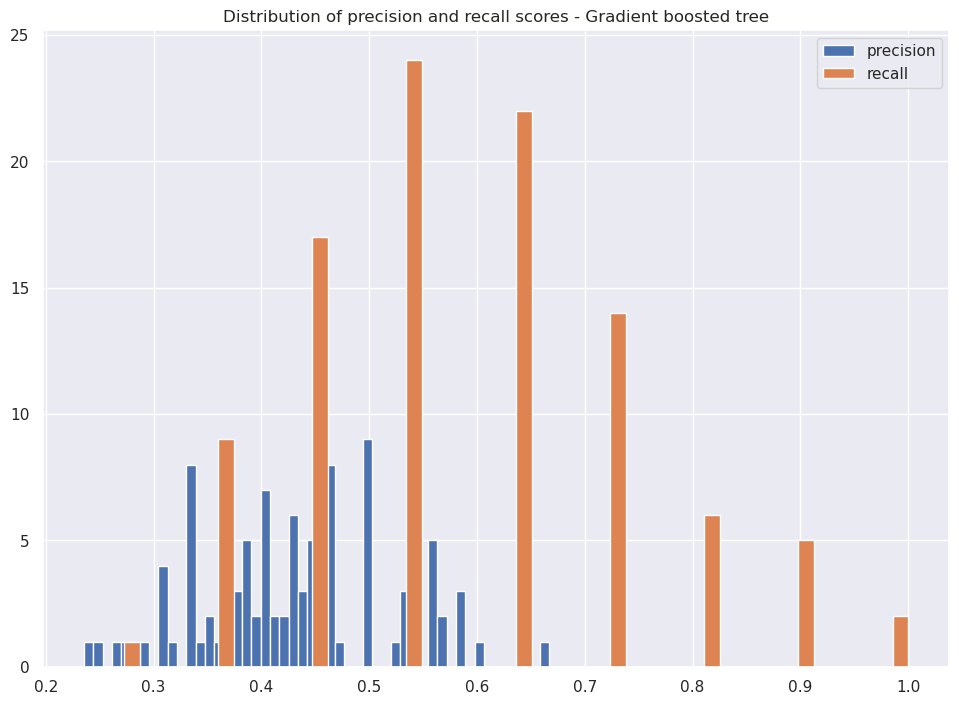

In [196]:
plt.hist(np.array(precision_GBT), bins = 50)
plt.hist(np.array(recall_GBT), bins = 50)
plt.title('Distribution of precision and recall scores - Gradient boosted tree')
plt.legend(['precision','recall'])
plt.show()

(array([63.,  4.,  2.,  0.,  1.,  1.,  1.,  0.,  0., 28.]),
 array([1.00000e-05, 1.00009e-01, 2.00008e-01, 3.00007e-01, 4.00006e-01,
        5.00005e-01, 6.00004e-01, 7.00003e-01, 8.00002e-01, 9.00001e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

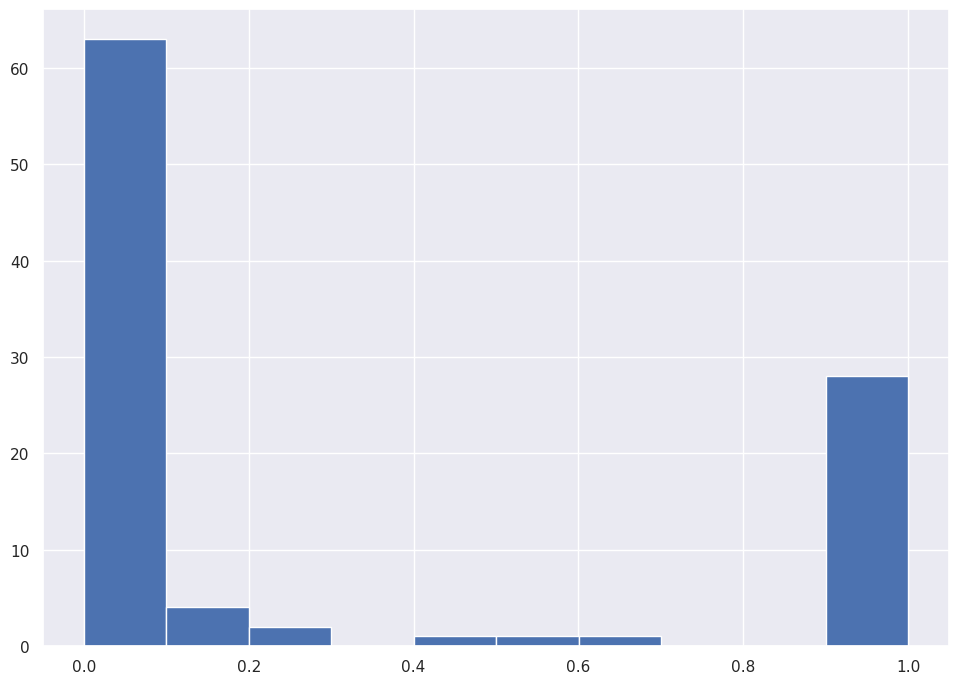

In [197]:
plt.hist(learning_rate_GBT)

(array([20., 13.,  7.,  4.,  5.,  4.,  1.,  9.,  6., 31.]),
 array([ 50.,  95., 140., 185., 230., 275., 320., 365., 410., 455., 500.]),
 <BarContainer object of 10 artists>)

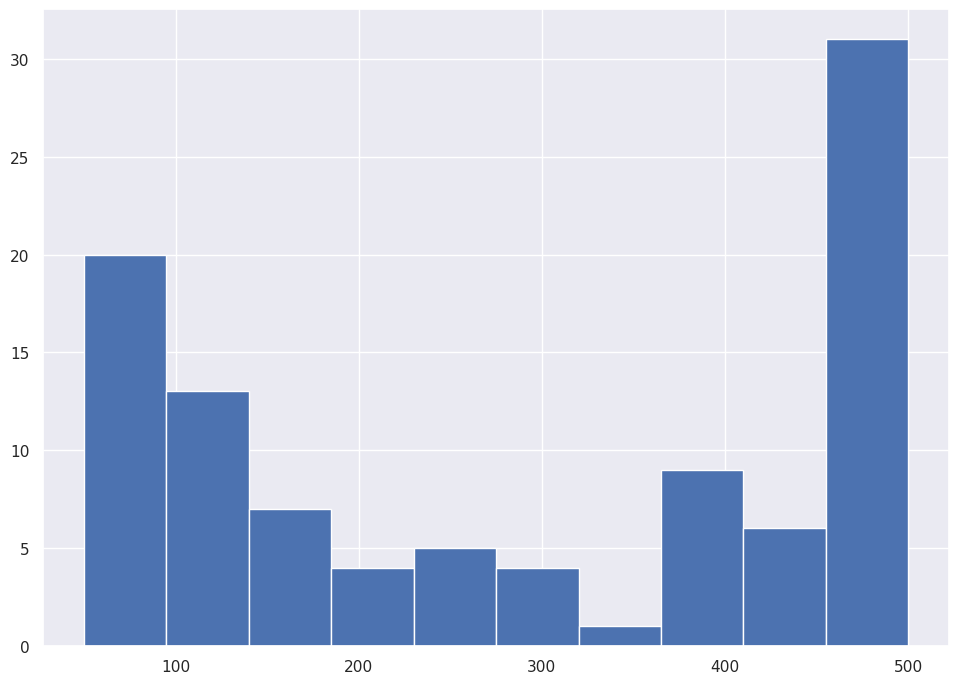

In [198]:
plt.hist(n_estimators_GBT)

### XGBoost

In [134]:
!pip install xgboost

  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [135]:
import xgboost.sklearn as xgb
n = 100
acc_XGBT = []
precision_XGBT = []
recall_XGBT = []
f1_XGBT =[]
learning_rate_XGBT =[]
n_estimators_XGBT = []
reg_alphas = []
reg_lambdas = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_XGBT = xgb.XGBClassifier(random_state = 0)
    space = [Integer(1, 10, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Real(10**-5, 10**0, "log-uniform", name='reg_alpha'),
             Real(10**-5, 10**0, "log-uniform", name='reg_lambda'),
             Integer(50, 500, name='n_estimators')]
    @use_named_args(space)
    def objective(**params):
        clf_XGBT.set_params(**params)
        return -np.mean(cross_val_score(clf_XGBT, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_XGBT_optim = xgb.XGBClassifier(random_state = 0, max_depth = res_gp.x[0], learning_rate = res_gp.x[1],
                                               reg_alpha = res_gp.x[2], reg_lambda = res_gp.x[3], 
                                               n_estimators = res_gp.x[4])
    learning_rate_XGBT.append(res_gp.x[1])
    n_estimators_XGBT.append(res_gp.x[4])
    reg_alphas.append(res_gp.x[2])
    reg_lambdas.append(res_gp.x[3])
        
    clf_XGBT_optim.fit(X_train, y_train)
    y_pred = clf_XGBT_optim.predict(X_test)
    acc_XGBT.append(accuracy_score(y_test, y_pred))
    precision_XGBT.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_XGBT.append(recall_score(y_test, y_pred))
    f1_XGBT.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_XGBT)}')
print(f'Accuracy scores standard deviation: {np.std(acc_XGBT)}')
print(f'F1 scores mean: {np.mean(f1_XGBT)}')
print(f'F1 scores mean standard deviation: {np.std(f1_XGBT)}')
print(f'precision scores mean: {np.mean(precision_XGBT)}')
print(f'precision scores standard deviation: {np.std(precision_XGBT)}')
print(f'Recall scores mean: {np.mean(recall_XGBT)}')
print(f'Recall scores standard deviation: {np.std(recall_XGBT)}')

Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30
Split 31
Split 32
Split 33
Split 34
Split 35
Split 36
Split 37
Split 38
Split 39
Split 40
Split 41
Split 42
Split 43
Split 44
Split 45
Split 46
Split 47
Split 48
Split 49
Split 50
Split 51
Split 52
Split 53
Split 54
Split 55
Split 56
Split 57
Split 58
Split 59
Split 60
Split 61


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 62
Split 63
Split 64
Split 65
Split 66
Split 67
Split 68
Split 69
Split 70
Split 71
Split 72
Split 73
Split 74
Split 75
Split 76
Split 77
Split 78
Split 79
Split 80
Split 81
Split 82
Split 83
Split 84
Split 85
Split 86
Split 87
Split 88
Split 89
Split 90
Split 91
Split 92
Split 93
Split 94
Split 95
Split 96
Split 97
Split 98
Split 99
Accuracy scores mean: 0.7703389830508471
Accuracy scores standard deviation: 0.053457046738678515
F1 scores mean: 0.8570950430721848
F1 scores mean standard deviation: 0.020797189267415007
precision scores mean: 0.4277698734097665
precision scores standard deviation: 0.09288428410576831
Recall scores mean: 0.6118181818181817
Recall scores standard deviation: 0.15790728527779097


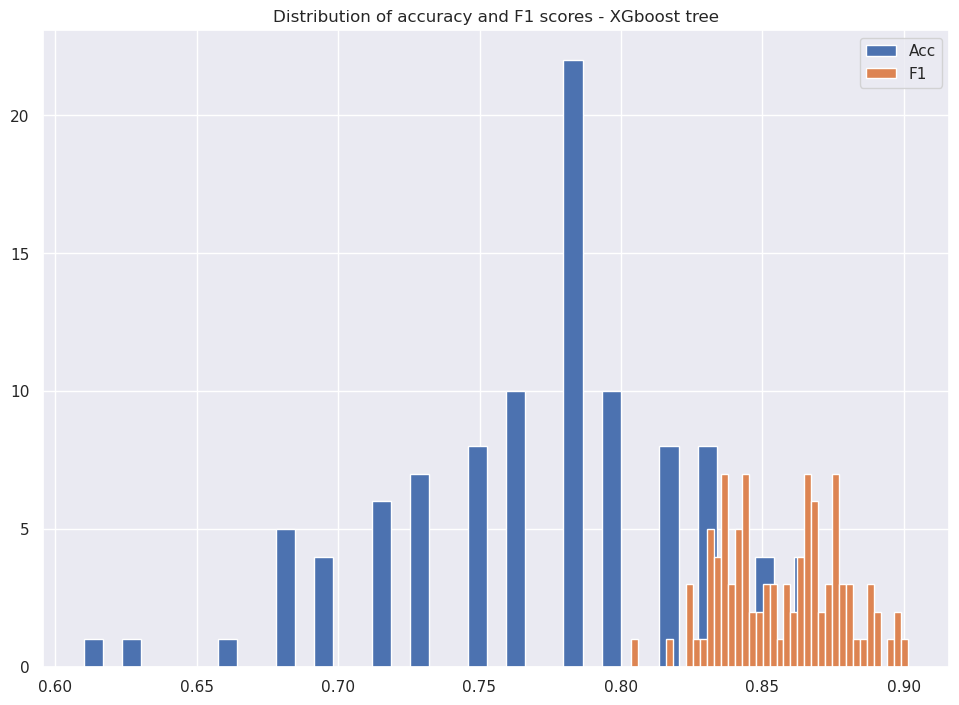

In [201]:
plt.hist(np.array(acc_XGBT), bins = 40)
plt.hist(np.array(f1_XGBT), bins = 40)
plt.title('Distribution of accuracy and F1 scores - XGboost tree')
plt.legend(['Acc','F1'])
plt.show()

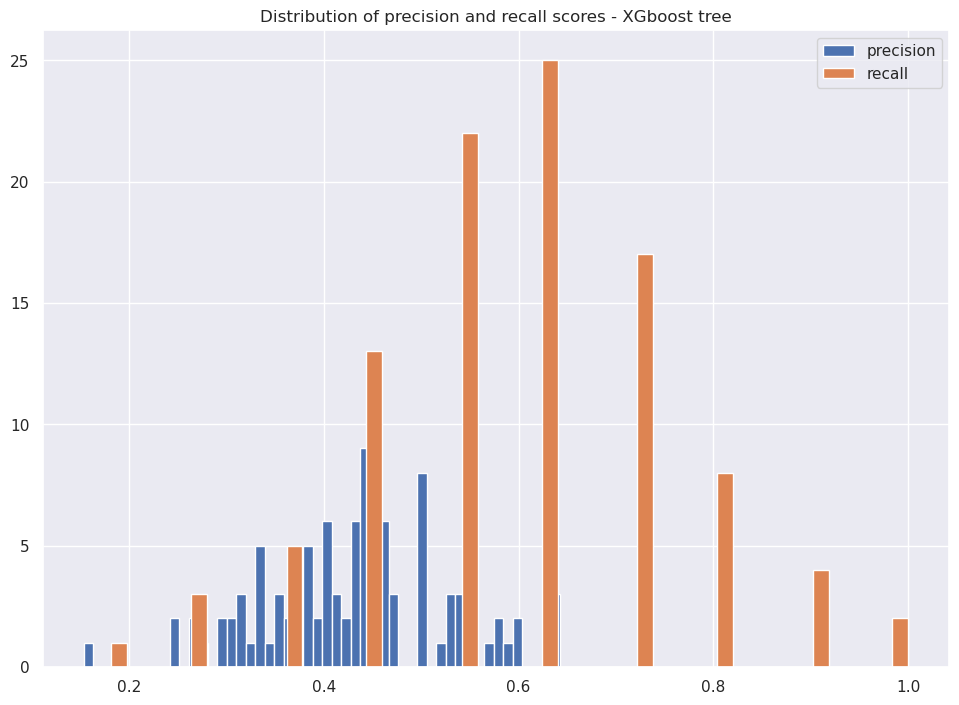

In [202]:
plt.hist(np.array(precision_XGBT), bins = 50)
plt.hist(np.array(recall_XGBT), bins = 50)
plt.title('Distribution of precision and recall scores - XGboost tree')
plt.legend(['precision','recall'])
plt.show()

(array([68., 15.,  4.,  7.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([1.00000e-05, 1.00009e-01, 2.00008e-01, 3.00007e-01, 4.00006e-01,
        5.00005e-01, 6.00004e-01, 7.00003e-01, 8.00002e-01, 9.00001e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

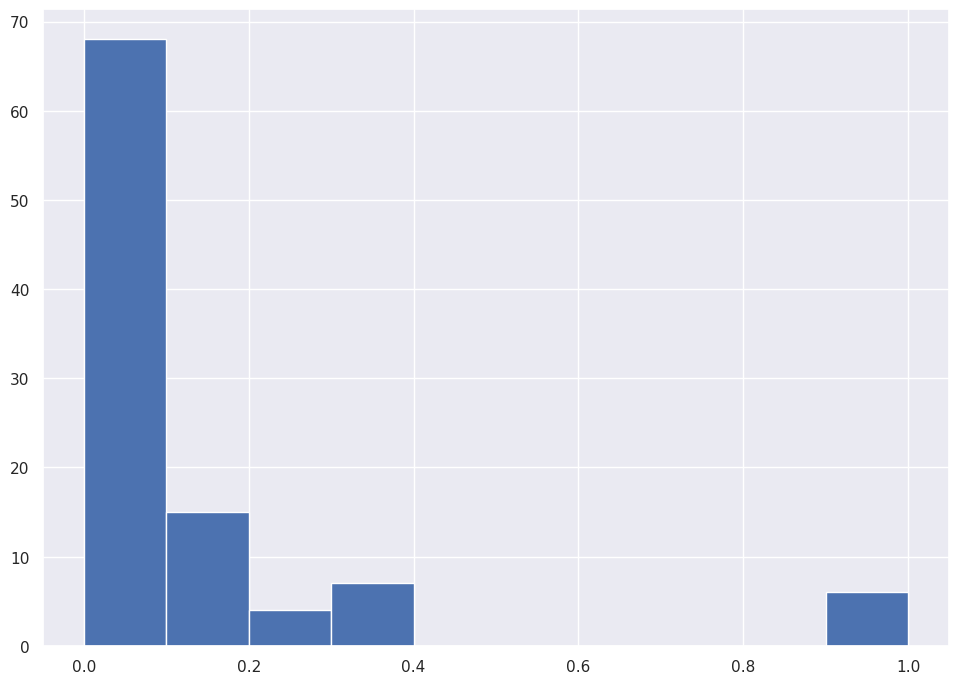

In [203]:
plt.hist(learning_rate_XGBT)

(array([20.,  5., 10., 16.,  8.,  5.,  7.,  7.,  1., 21.]),
 array([ 50.,  95., 140., 185., 230., 275., 320., 365., 410., 455., 500.]),
 <BarContainer object of 10 artists>)

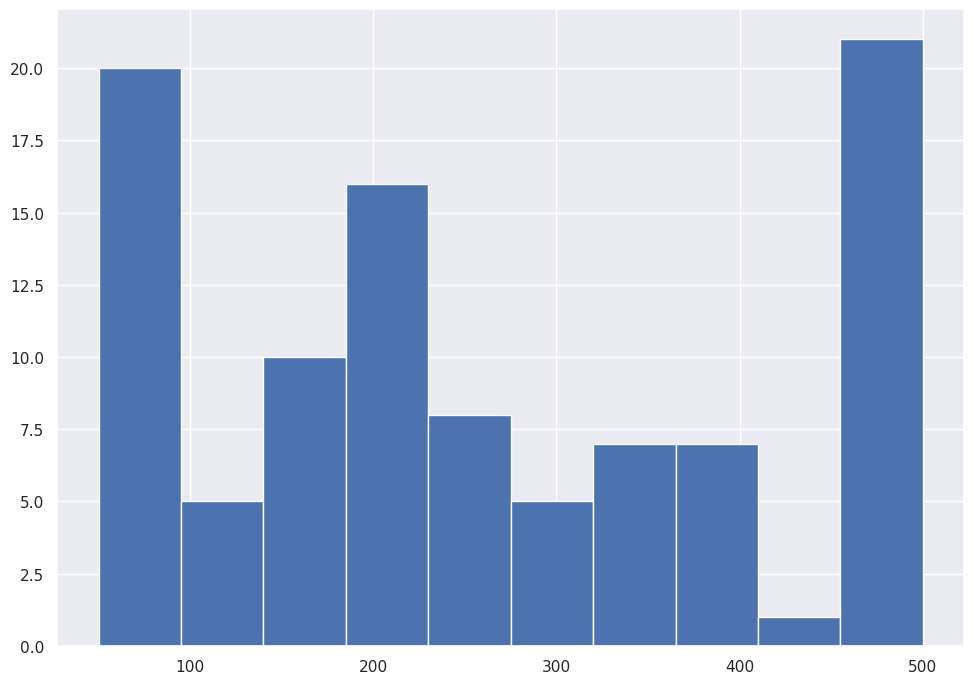

In [204]:
plt.hist(n_estimators_XGBT)

(array([77.,  3.,  3.,  2.,  0.,  0.,  0.,  0.,  0., 15.]),
 array([1.00000e-05, 1.00009e-01, 2.00008e-01, 3.00007e-01, 4.00006e-01,
        5.00005e-01, 6.00004e-01, 7.00003e-01, 8.00002e-01, 9.00001e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

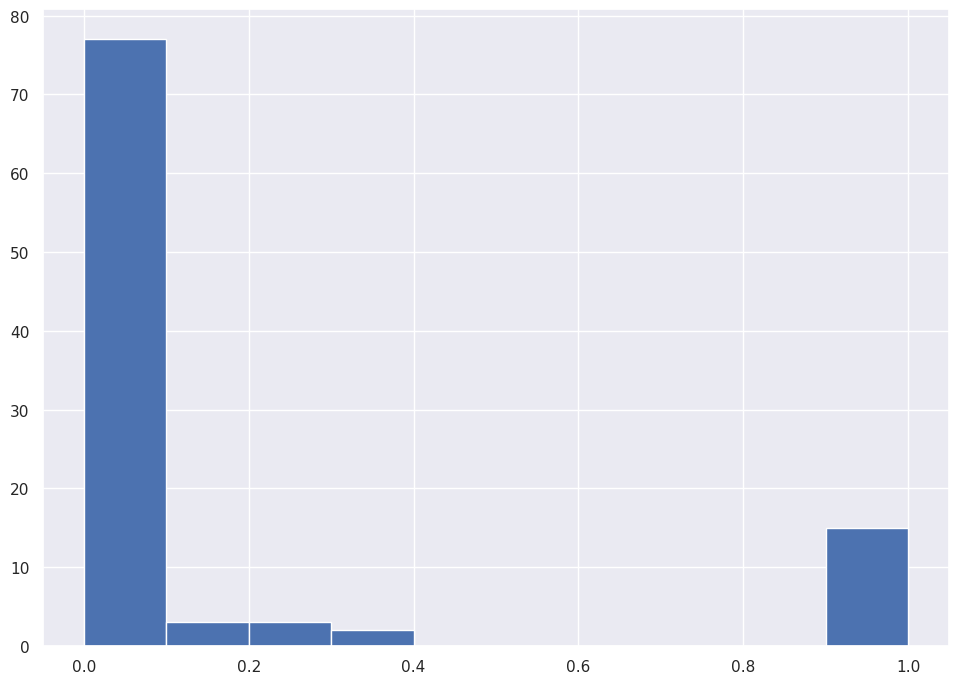

In [205]:
plt.hist(reg_alphas)

(array([75.,  5.,  0.,  0.,  2.,  1.,  0.,  7.,  0., 10.]),
 array([1.00000e-05, 1.00009e-01, 2.00008e-01, 3.00007e-01, 4.00006e-01,
        5.00005e-01, 6.00004e-01, 7.00003e-01, 8.00002e-01, 9.00001e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

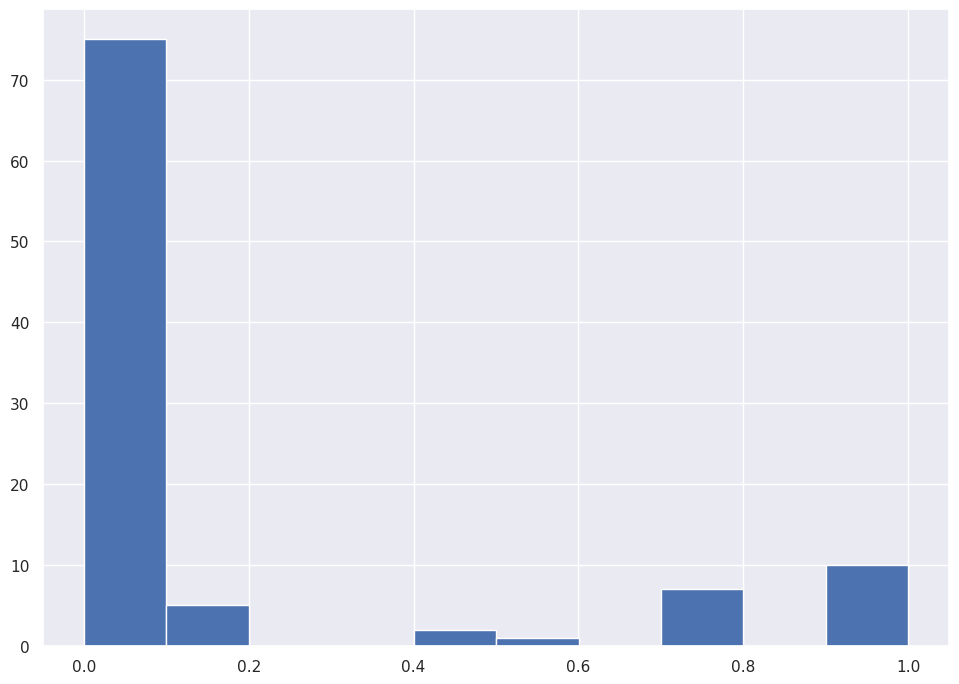

In [206]:
plt.hist(reg_lambdas)

### Logistic regression

In [142]:
from sklearn.linear_model import LogisticRegression
n = 100
acc_logit = []
precision_logit = []
recall_logit = []
f1_logit =[]
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_logit = LogisticRegression(random_state = 0).fit(X_train, y_train)
    y_pred = clf_logit.predict(X_test)
    acc_logit.append(accuracy_score(y_test, y_pred))
    precision_logit.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_logit.append(recall_score(y_test, y_pred))
    f1_logit.append(f1_score(y_test, y_pred))
            
            
print(f'Accuracy scores mean: {np.mean(acc_logit)}')
print(f'Accuracy scores standard deviation: {np.std(acc_logit)}')
print(f'F1 scores mean: {np.mean(f1_logit)}')
print(f'F1 scores mean standard deviation: {np.std(f1_logit)}')
print(f'precision scores mean: {np.mean(precision_logit)}')
print(f'precision scores standard deviation: {np.std(precision_logit)}')
print(f'Recall scores mean: {np.mean(recall_logit)}')
print(f'Recall scores standard deviation: {np.std(recall_logit)}')

Accuracy scores mean: 0.7938983050847458
Accuracy scores standard deviation: 0.047742486485310515
F1 scores mean: 0.5290055308812441
F1 scores mean standard deviation: 0.10511685699660105
precision scores mean: 0.4664284075487636
precision scores standard deviation: 0.09853159882081622
Recall scores mean: 0.6245454545454545
Recall scores standard deviation: 0.145826229657762


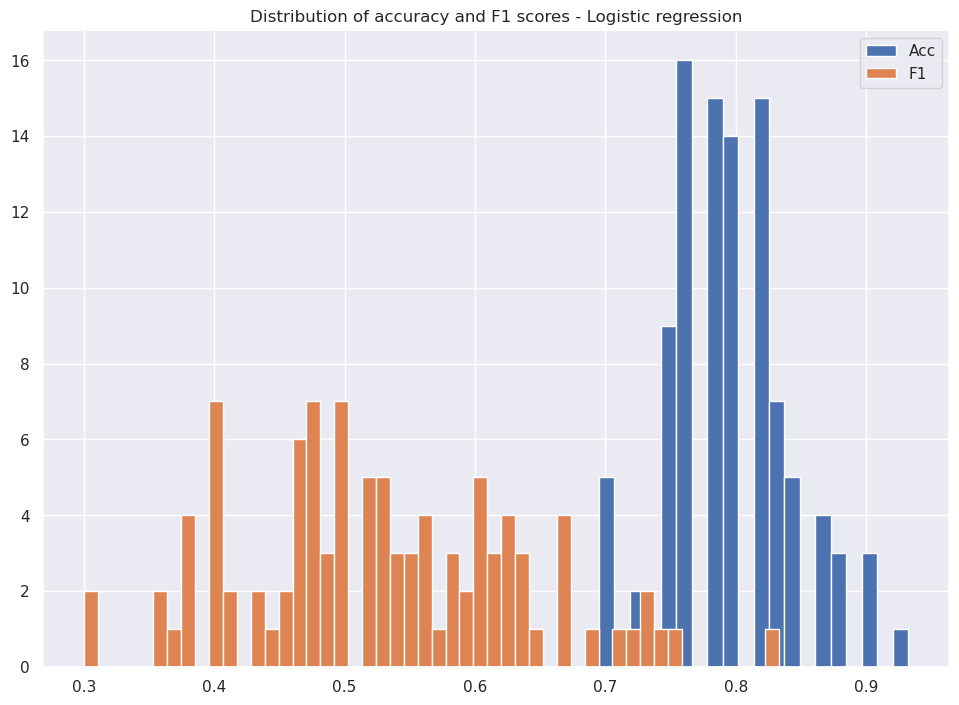

In [207]:
plt.hist(np.array(acc_logit), bins = 20)
plt.hist(np.array(f1_logit), bins = 50)
plt.title('Distribution of accuracy and F1 scores - Logistic regression')
plt.legend(['Acc','F1'])
plt.show()

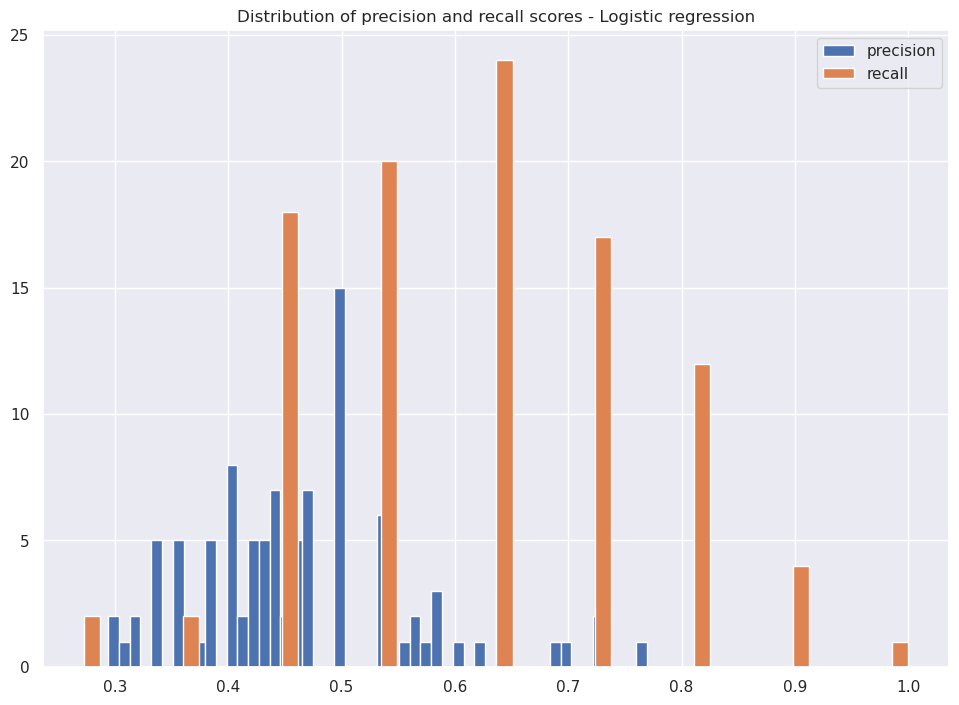

In [208]:
plt.hist(np.array(precision_logit), bins = 50)
plt.hist(np.array(recall_logit), bins = 50)
plt.title('Distribution of precision and recall scores - Logistic regression')
plt.legend(['precision','recall'])
plt.show()

### KNN

In [147]:
from sklearn.neighbors import KNeighborsClassifier
n = 100
acc_knn = []
precision_knn = []
recall_knn = []
f1_knn = []
neighbors = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_knn = KNeighborsClassifier()
    space = [Integer(1, 10, name='n_neighbors')]
    @use_named_args(space)
    def objective(**params):
        clf_knn.set_params(**params)
        return -np.mean(cross_val_score(clf_knn, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=12, random_state=0)
    clf_knn_optim = KNeighborsClassifier(n_neighbors = res_gp.x[0])
    neighbors.append(res_gp.x[0])  
    
    clf_knn_optim.fit(X_train, y_train)
    y_pred = clf_knn_optim.predict(X_test)
    acc_knn.append(accuracy_score(y_test, y_pred))
    precision_knn.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_knn.append(recall_score(y_test, y_pred))
    f1_knn.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_knn)}')
print(f'Accuracy scores standard deviation: {np.std(acc_knn)}')
print(f'F1 scores mean: {np.mean(f1_knn)}')
print(f'F1 scores mean standard deviation: {np.std(f1_knn)}')
print(f'precision scores mean: {np.mean(precision_knn)}')
print(f'precision scores standard deviation: {np.std(precision_knn)}')
print(f'Recall scores mean: {np.mean(recall_knn)}')
print(f'Recall scores standard deviation: {np.std(recall_knn)}')

/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 2
Split 3


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 4


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 5


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 6
Split 7
Split 8


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 9


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 10


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 11


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 12


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 13


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 14


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 15


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 16
Split 17


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 18


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 19


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 20


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 21


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 22


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 23


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 24
Split 25


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 26


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 27


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 28


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 29
Split 30


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 31


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 32
Split 33


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 34
Split 35


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 36


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 37


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 38


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 39


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 40


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 41
Split 42


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 43


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 44
Split 45
Split 46
Split 47


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 48


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 49


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 50


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 51


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 52


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 53
Split 54
Split 55


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 56


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 57
Split 58


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 59


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 60


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 61


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 62


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 63


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 64


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 65
Split 66


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 67


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 68


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 69
Split 70
Split 71


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 72


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 73


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 74


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 75
Split 76


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 77


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 78


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 79


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 80
Split 81


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 82
Split 83
Split 84


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 85


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 86


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 87


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 88


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 89


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 90


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 91
Split 92
Split 93


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 94
Split 95


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 96
Split 97


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 98
Split 99
Accuracy scores mean: 0.5920338983050848
Accuracy scores standard deviation: 0.08104655157362615
F1 scores mean: 0.784923489883136
F1 scores mean standard deviation: 0.023369711372452612
precision scores mean: 0.23680507721757366
precision scores standard deviation: 0.06508707188567556
Recall scores mean: 0.5363636363636364
Recall scores standard deviation: 0.2094857931236893


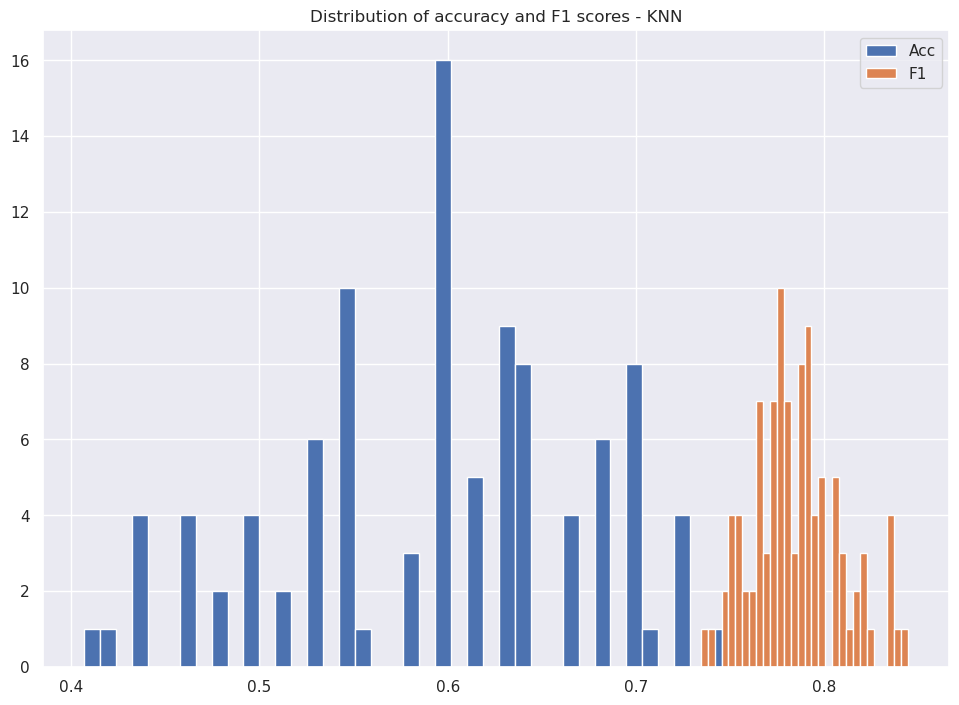

In [211]:
plt.hist(np.array(acc_knn), bins = 40)
plt.hist(np.array(f1_knn), bins = 30)
plt.title('Distribution of accuracy and F1 scores - KNN')
plt.legend(['Acc','F1'])
plt.show()

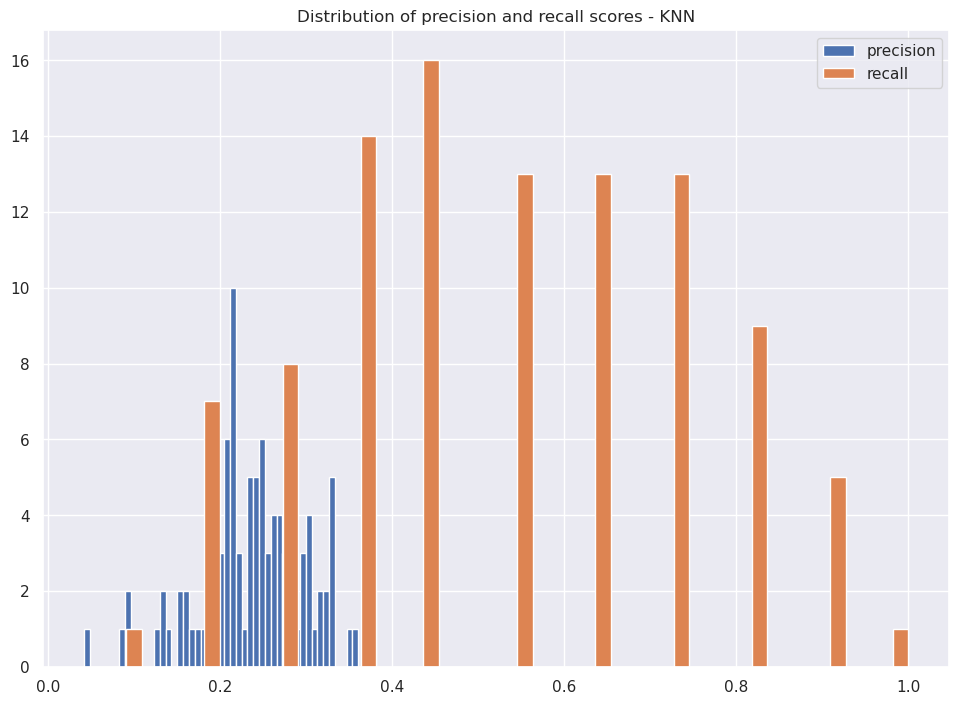

In [212]:
plt.hist(np.array(precision_knn), bins = 50)
plt.hist(np.array(recall_knn), bins = 50)
plt.title('Distribution of precision and recall scores - KNN')
plt.legend(['precision','recall'])
plt.show()

(array([28.,  0., 47.,  0., 18.,  0.,  5.,  0.,  0.,  2.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

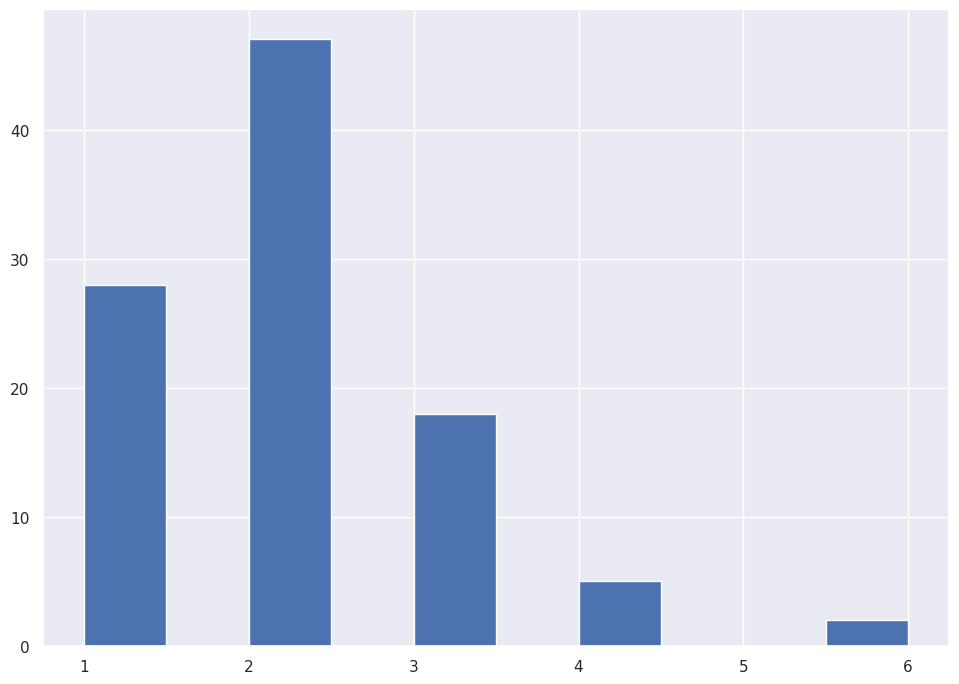

In [213]:
plt.hist(neighbors)

### SVM

In [151]:
from sklearn.svm import SVC
from skopt.space import Categorical
n = 100
acc_svm = []
precision_svm = []
recall_svm = []
f1_svm =[]
kernels = []
Cs = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_svm = SVC(random_state = 0)
    space = [Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'),
             Real(10**-2, 10**2, "log-uniform", name='C')]
    @use_named_args(space)
    def objective(**params):
        clf_svm.set_params(**params)
        return -np.mean(cross_val_score(clf_svm, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_svm_optim = SVC(random_state = 0, kernel = res_gp.x[0], C = res_gp.x[1])
    kernels.append(res_gp.x[0])
    Cs.append(res_gp.x[1])
    
    clf_svm_optim.fit(X_train, y_train)
    y_pred = clf_svm_optim.predict(X_test)
    acc_svm.append(accuracy_score(y_test, y_pred))
    precision_svm.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_svm.append(recall_score(y_test, y_pred))
    f1_svm.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_svm)}')
print(f'Accuracy scores standard deviation: {np.std(acc_svm)}')
print(f'F1 scores mean: {np.mean(f1_svm)}')
print(f'F1 scores mean standard deviation: {np.std(f1_svm)}')
print(f'precision scores mean: {np.mean(precision_svm)}')
print(f'precision scores standard deviation: {np.std(precision_svm)}')
print(f'Recall scores mean: {np.mean(recall_svm)}')
print(f'Recall scores standard deviation: {np.std(recall_svm)}')

Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 2


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 3
Split 4
Split 5


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 6
Split 7


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 8
Split 9


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 10
Split 11
Split 12
Split 13
Split 14


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 15


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 16
Split 17
Split 18
Split 19
Split 20
Split 21


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 22


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 23
Split 24
Split 25
Split 26


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 27


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 28
Split 29
Split 30
Split 31
Split 32
Split 33


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 34
Split 35
Split 36
Split 37
Split 38


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 39


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 40
Split 41


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 42


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 43
Split 44
Split 45
Split 46
Split 47


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 48


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 49


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 50
Split 51
Split 52
Split 53
Split 54


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 55
Split 56


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 57


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 58


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 59
Split 60


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 61


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 62
Split 63
Split 64
Split 65
Split 66


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 67
Split 68
Split 69
Split 70
Split 71


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 72
Split 73


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 74


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 75
Split 76
Split 77


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 78
Split 79
Split 80
Split 81


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 82


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 83
Split 84


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 85


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 86


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 87


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 88


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site

Split 89
Split 90
Split 91
Split 92
Split 93
Split 94
Split 95
Split 96
Split 97
Split 98


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 99
Accuracy scores mean: 0.7715254237288136
Accuracy scores standard deviation: 0.061180571576346876
F1 scores mean: 0.8425469148650226
F1 scores mean standard deviation: 0.021950053663296384
precision scores mean: 0.4387549398904413
precision scores standard deviation: 0.11766040534667115
Recall scores mean: 0.5972727272727272
Recall scores standard deviation: 0.1711675994674168


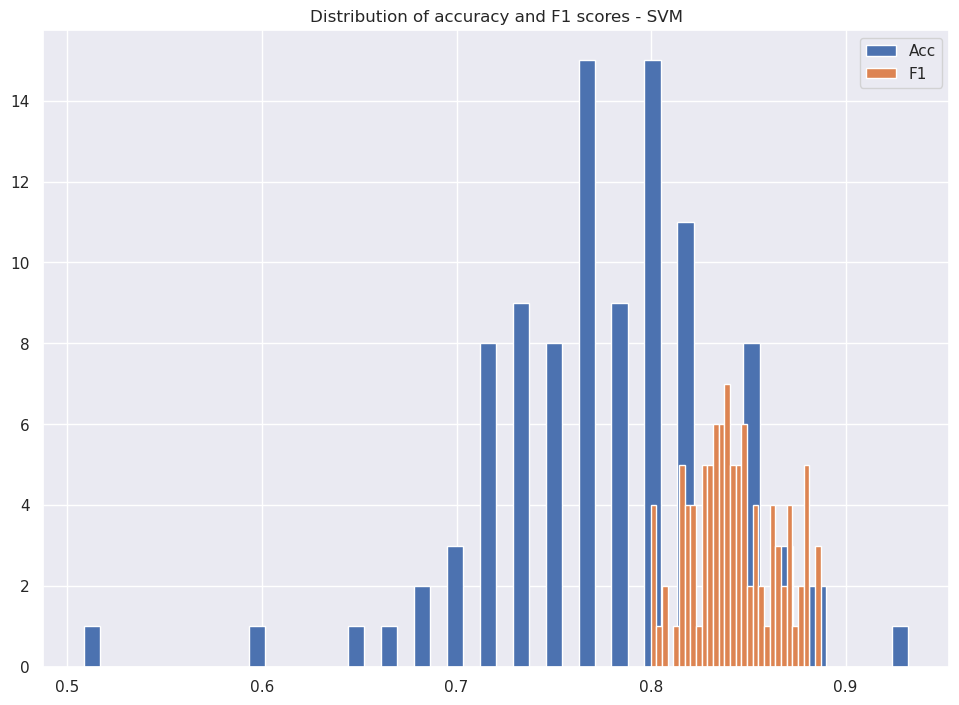

In [215]:
plt.hist(np.array(acc_svm), bins = 50)
plt.hist(np.array(f1_svm), bins = 30)
plt.title('Distribution of accuracy and F1 scores - SVM')
plt.legend(['Acc','F1'])
plt.show()

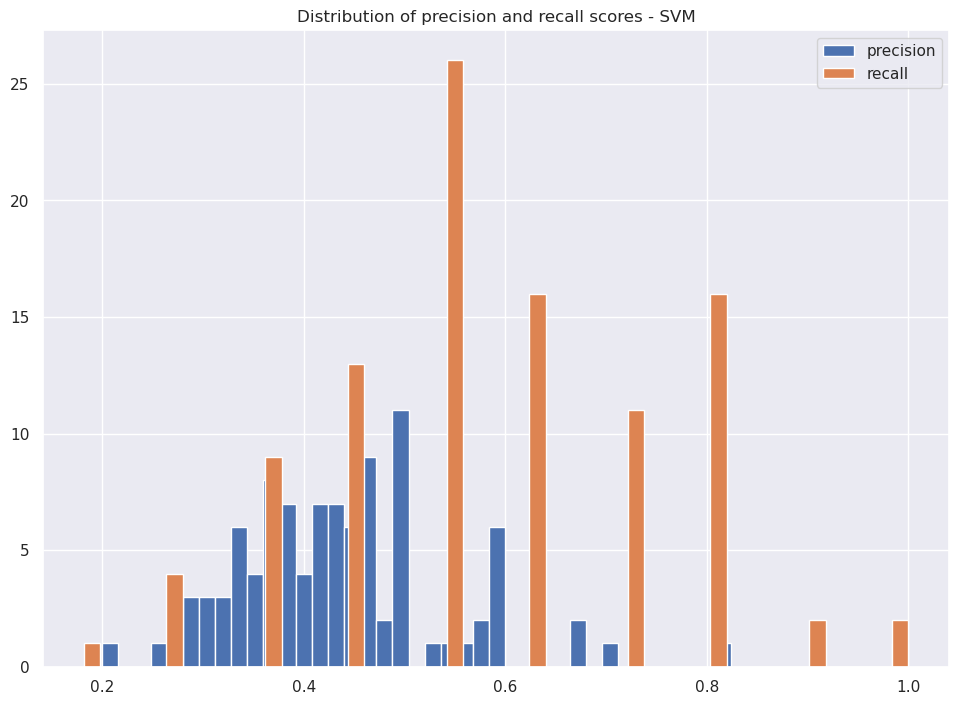

In [216]:
plt.hist(np.array(precision_svm), bins = 50)
plt.hist(np.array(recall_svm), bins = 50)
plt.title('Distribution of precision and recall scores - SVM')
plt.legend(['precision','recall'])
plt.show()

(array([75.,  0.,  0., 10.,  0.,  0.,  4.,  0.,  0., 11.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

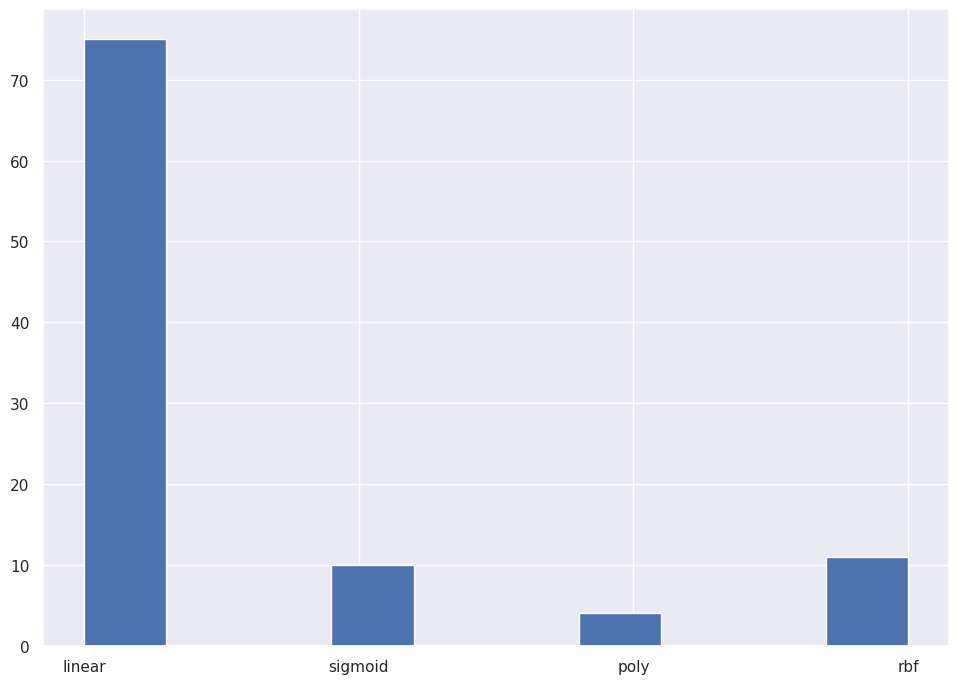

In [217]:
plt.hist(kernels)

(array([86.,  3.,  7.,  2.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([1.0000e-02, 1.0009e+01, 2.0008e+01, 3.0007e+01, 4.0006e+01,
        5.0005e+01, 6.0004e+01, 7.0003e+01, 8.0002e+01, 9.0001e+01,
        1.0000e+02]),
 <BarContainer object of 10 artists>)

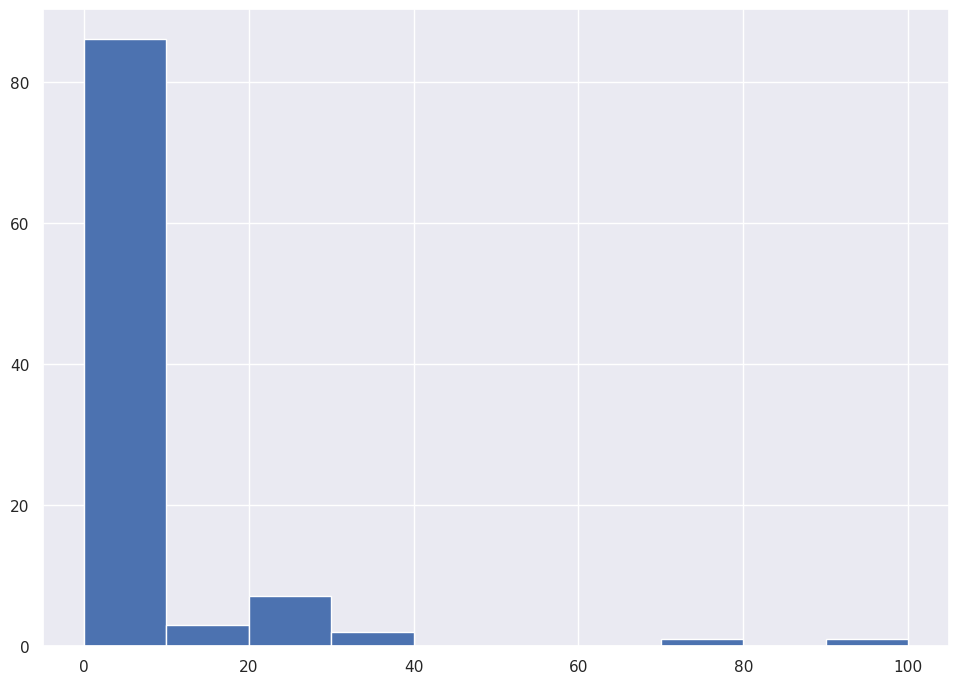

In [218]:
plt.hist(Cs)

### MLP

In [158]:
from sklearn.neural_network import MLPClassifier
X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, 0)
X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

clf_mlp = MLPClassifier(random_state = 0, hidden_layer_sizes=(5,), max_iter = 2000)
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8135593220338984
0.56


In [159]:
from sklearn.neural_network import MLPClassifier
n = 100
acc_mlp = []
precision_mlp = []
recall_mlp = []
f1_mlp =[]
activations = []
alphas = []
n_hidden_layers = []
n_neurons_per_layer = []
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs*1234+567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_mlp = MLPClassifier(random_state = 0, max_iter = 3000)
    space = [Categorical(['tanh','relu'], name = 'activation'),
             Real(10**-5, 10**-1, "log-uniform", name = 'alpha'),
             Integer(10, 100, name='n_neurons_per_layer'), 
             Integer(1, 4, name = 'n_hidden_layer')]
    @use_named_args(space)
    def objective(**params):
        n_neurons = params['n_neurons_per_layer']
        n_layers = params['n_hidden_layer']
        params['hidden_layer_sizes'] = (n_neurons,)*n_layers
        params.pop('n_neurons_per_layer')
        params.pop('n_hidden_layer')
        clf_mlp.set_params(**params)
        return -np.mean(cross_val_score(clf_mlp, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    clf_mlp_optim = MLPClassifier(random_state = 0, max_iter = 3000, activation = res_gp.x[0], alpha = res_gp.x[1], hidden_layer_sizes = (res_gp.x[2],)*res_gp.x[3])
    activations.append(res_gp.x[0])
    alphas.append(res_gp.x[1])
    n_neurons_per_layer.append(res_gp.x[2])
    n_hidden_layers.append(res_gp.x[3])
    
    clf_mlp_optim.fit(X_train, y_train)
    y_pred = clf_mlp_optim.predict(X_test)
    acc_mlp.append(accuracy_score(y_test, y_pred))
    precision_mlp.append(precision_score(y_test, y_pred, zero_division = 1))
    recall_mlp.append(recall_score(y_test, y_pred))
    f1_mlp.append(np.abs(res_gp.fun))
    print("Split %s" % rs)


print(f'Accuracy scores mean: {np.mean(acc_mlp)}')
print(f'Accuracy scores standard deviation: {np.std(acc_mlp)}')
print(f'F1 scores mean: {np.mean(f1_mlp)}')
print(f'F1 scores mean standard deviation: {np.std(f1_mlp)}')
print(f'precision scores mean: {np.mean(precision_mlp)}')
print(f'precision scores standard deviation: {np.std(precision_mlp)}')
print(f'Recall scores mean: {np.mean(recall_mlp)}')
print(f'Recall scores standard deviation: {np.std(recall_mlp)}')

Split 0


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 1
Split 2
Split 3


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 4
Split 5
Split 6


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 7
Split 8


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 16


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 31
Split 32
Split 33
Split 34
Split 35


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 36
Split 37


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 38


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 39
Split 40


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 41


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 42
Split 43
Split 44
Split 45
Split 46
Split 47
Split 48
Split 49
Split 50
Split 51
Split 52


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 53
Split 54
Split 55


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 56
Split 57
Split 58
Split 59


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 60
Split 61
Split 62
Split 63
Split 64


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 65
Split 66
Split 67
Split 68
Split 69
Split 70
Split 71
Split 72
Split 73
Split 74
Split 75


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 76
Split 77


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 78
Split 79
Split 80
Split 81
Split 82
Split 83
Split 84


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 85
Split 86
Split 87
Split 88
Split 89
Split 90
Split 91


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 92
Split 93
Split 94
Split 95


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 96


/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Split 97
Split 98
Split 99
Accuracy scores mean: 0.7852542372881356
Accuracy scores standard deviation: 0.047521446193476154
F1 scores mean: 0.8545204444193589
F1 scores mean standard deviation: 0.021230120556610933
precision scores mean: 0.4472522617990885
precision scores standard deviation: 0.10178970415036312
Recall scores mean: 0.5554545454545454
Recall scores standard deviation: 0.1509720569624428


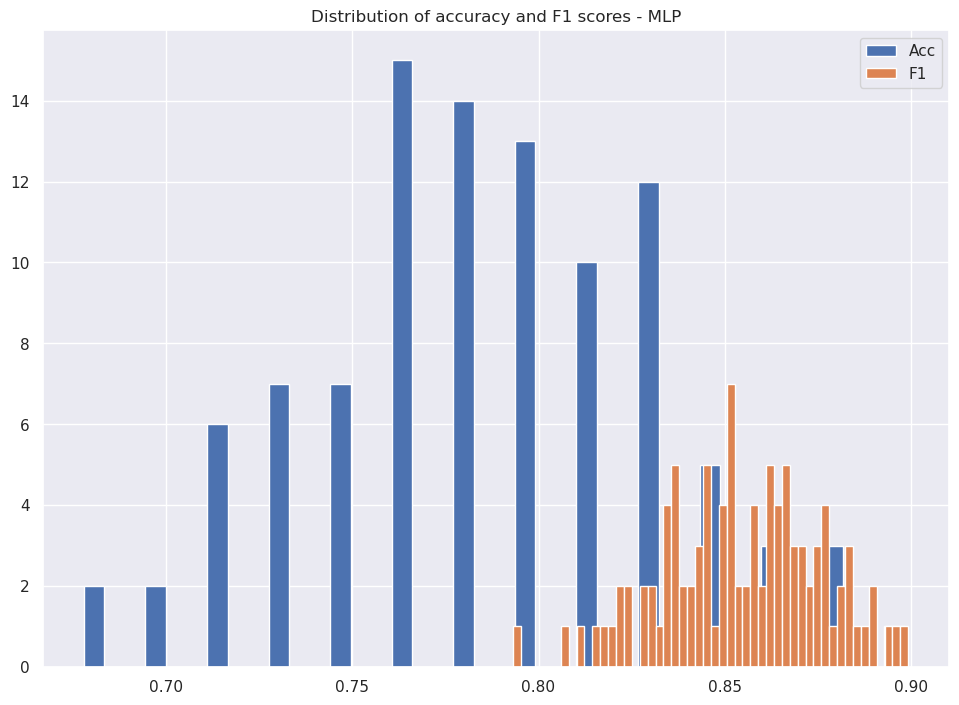

In [219]:
plt.hist(np.array(acc_mlp), bins = 40)
plt.hist(np.array(f1_mlp), bins = 50)
plt.title('Distribution of accuracy and F1 scores - MLP')
plt.legend(['Acc','F1'])
plt.show()

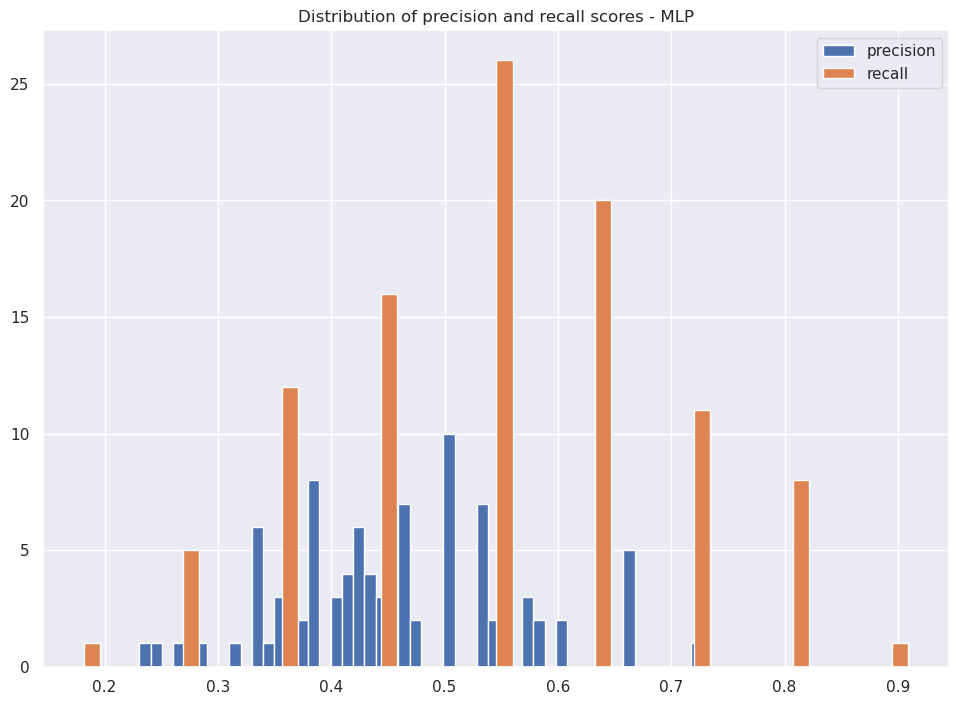

In [220]:
plt.hist(np.array(precision_mlp), bins = 50)
plt.hist(np.array(recall_mlp), bins = 50)
plt.title('Distribution of precision and recall scores - MLP')
plt.legend(['precision','recall'])
plt.show()

(array([97.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

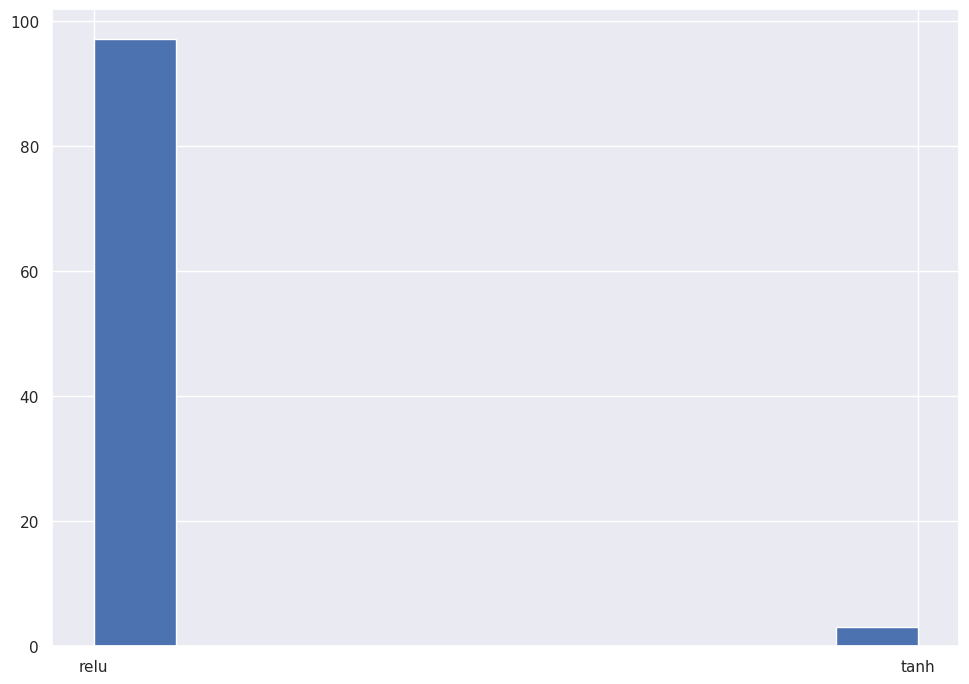

In [221]:
plt.hist(activations)

(array([68.,  3.,  7.,  2.,  0.,  1.,  6.,  5.,  1.,  7.]),
 array([1.0000e-05, 1.0009e-02, 2.0008e-02, 3.0007e-02, 4.0006e-02,
        5.0005e-02, 6.0004e-02, 7.0003e-02, 8.0002e-02, 9.0001e-02,
        1.0000e-01]),
 <BarContainer object of 10 artists>)

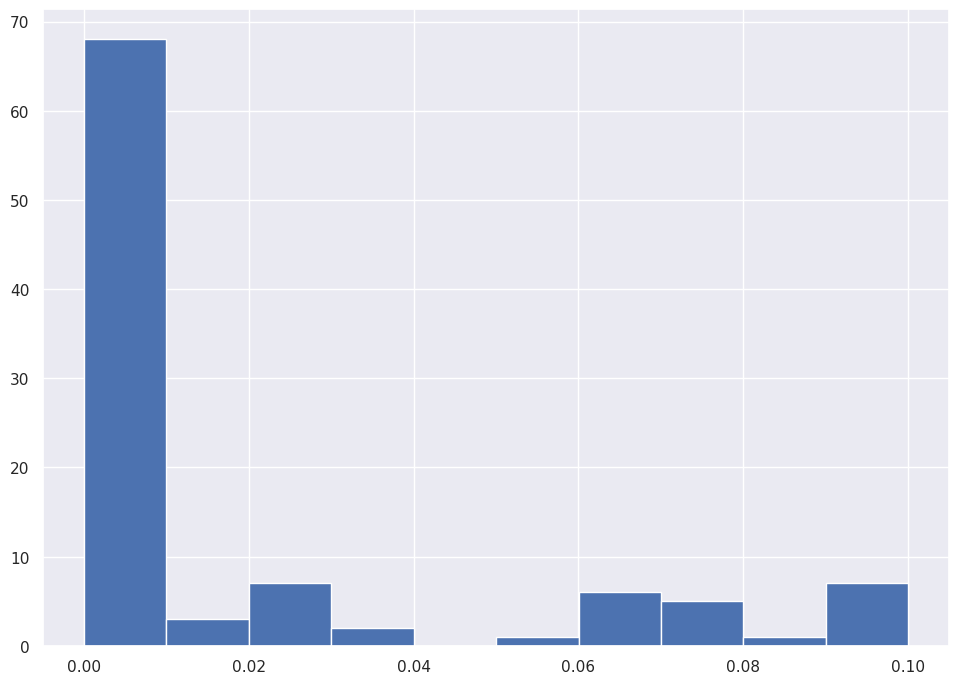

In [222]:
plt.hist(alphas)

(array([23.,  0.,  0., 42.,  0.,  0., 12.,  0.,  0., 23.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

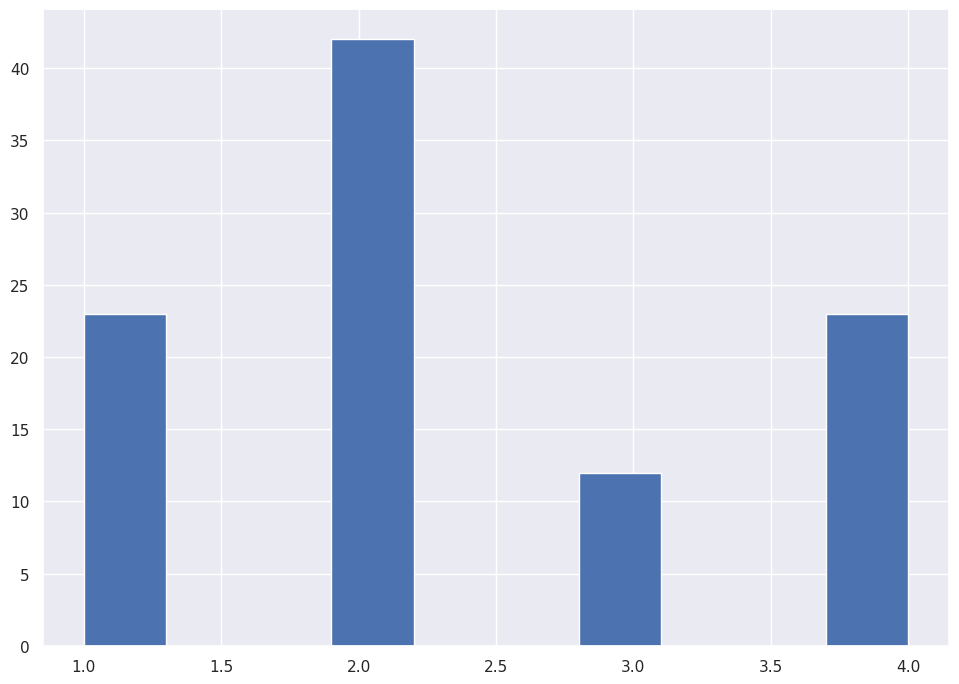

In [223]:
plt.hist(n_hidden_layers)

(array([12.,  6.,  1., 14.,  3.,  4.,  6.,  2., 16., 36.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

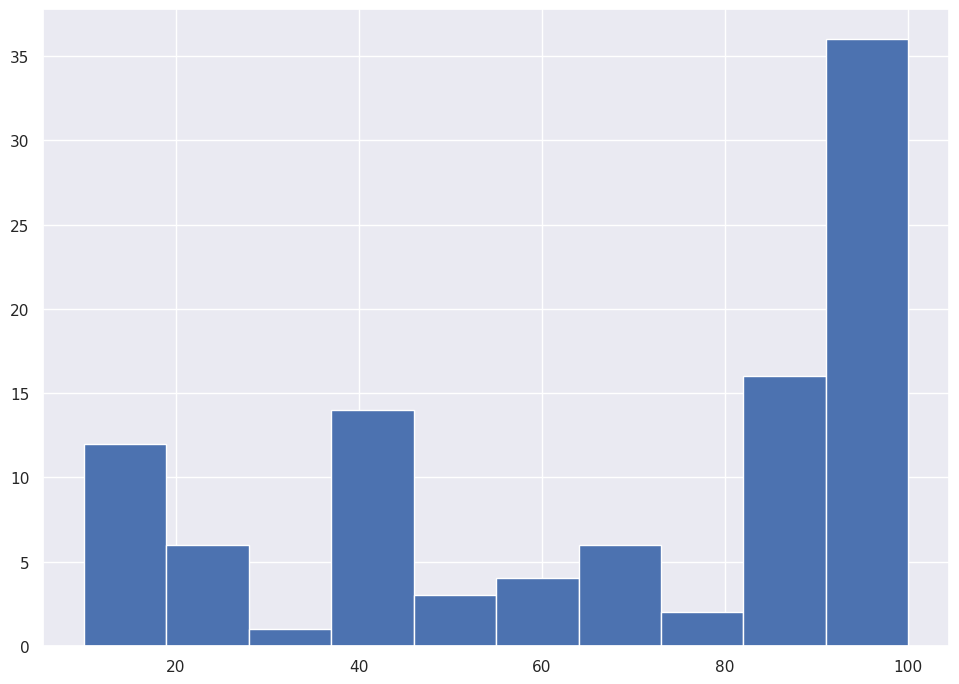

In [224]:
plt.hist(n_neurons_per_layer)

### Results summary

|                                 |        Accuracy        |        F1 score        |  
|---------------------------------|:----------------------:|:----------------------:|
|          Decision tree          | 0.77(0.049)     | 0.47(0.099)     |
| Decision tree with pre-pruning  | 0.75(0.075) | 0.84(0.026)                    |
| Decision tree with post-pruning | 0.81(0.043) | 0.55(0.096)                    |
| **Random forest**                   | 0.77(0.052)     | **0.86**(0.020)    |
| **Gradient boosting tree**           | 0.78(0.053)     | **0.86**(0.019)     |
| **XGBoost**                         | 0.77(0.053) | **0.86**(0.021)   |
| Logistic regression             | 0.79(0.048)     | 0.53(0.105)    |
| KNN                             | 0.59(0.081)     | 0.78(0.023)    |
| SVM                         | 0.77(0.061)  | 0.84(0.022) |
|MLP                          |0.79(0.048)|0.85(0.021)|

Comparing to simple decision tree as baseline, accuracy score is enhanced by all methods except K-NN and pre-pruned decision tree. F1 score is improved by all methods. The top 3 performers in tare SVM, MLP and naïve bayes classifers.

However, our analysis is subject to the limitation that our test set has only a size of 59. An increase of accuracy from 0.81 to 0.83 actually mean only 1 additional correct prediction. Therefore, the improvements in score may only be subtle.

In [167]:
acc_scores_comb = acc_tree + acc_preprun + acc_postprun + acc_forest + acc_GBT + acc_XGBT + acc_logit + acc_knn + acc_svm + acc_mlp
f1_scores_comb = f1_tree + f1_preprun + f1_postprun + f1_forest + f1_GBT + f1_XGBT + f1_logit + f1_knn + f1_svm + f1_mlp
methods = ['Tree', 'Preprun', 'Postprun', 'Forest', 'GBT', 'XGBT', 'logit', 'KNN', 'SVM', 'MLP']
M = []
for e in methods:
    M.extend([e]*100)

df = pd.DataFrame(M, columns = ['Methods'])
df['Acc'] = acc_scores_comb
df['F1'] = f1_scores_comb

[Text(0.5, 1.0, 'Empirical distribtion of accuracy scores')]

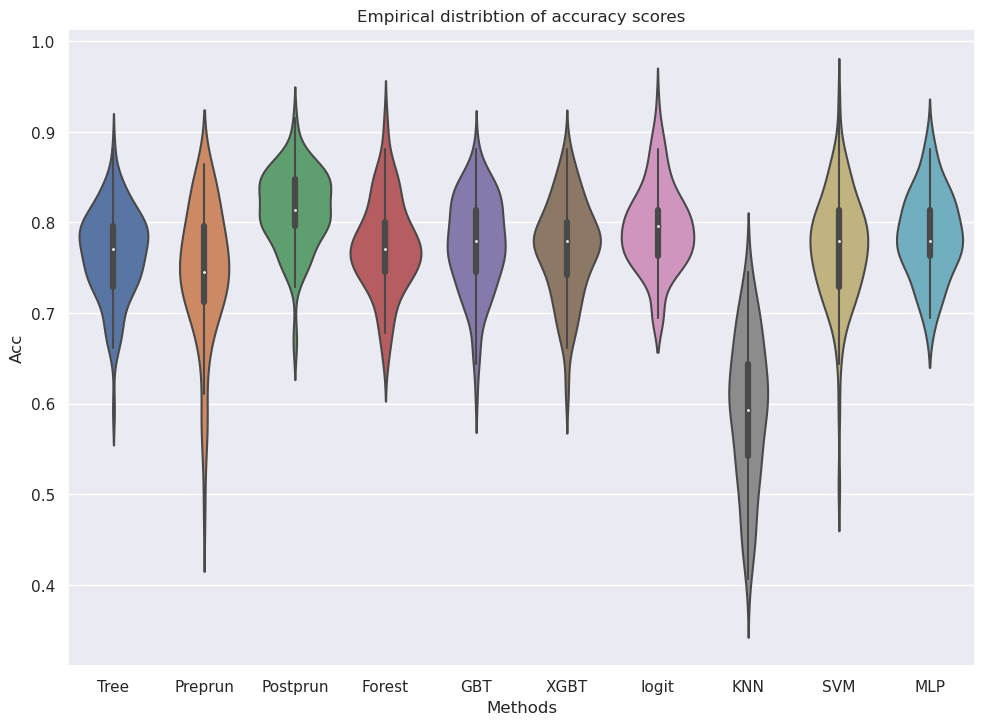

In [168]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.color_palette("pastel")
sns.violinplot(df, x = 'Methods', y = 'Acc').set(title = 'Empirical distribtion of accuracy scores')

[Text(0.5, 1.0, 'Empirical distribtion of F1 scores')]

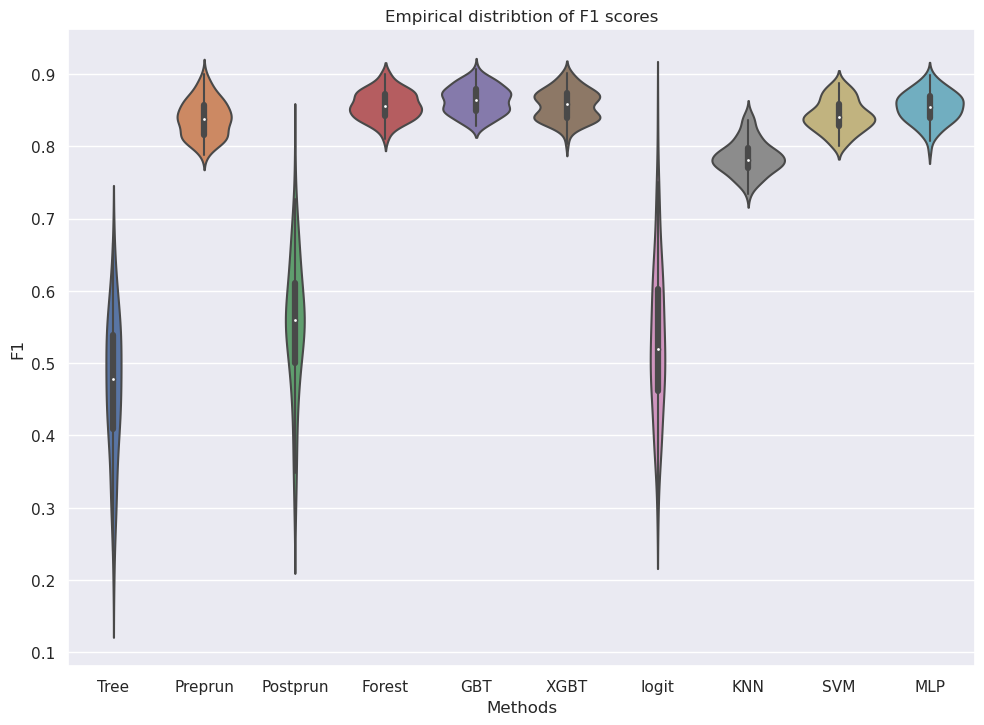

In [169]:
sns.violinplot(df, x = 'Methods', y = 'F1').set(title = 'Empirical distribtion of F1 scores')

In [170]:
any(df['F1']<0)

False

<Axes: xlabel='Methods', ylabel='F1'>

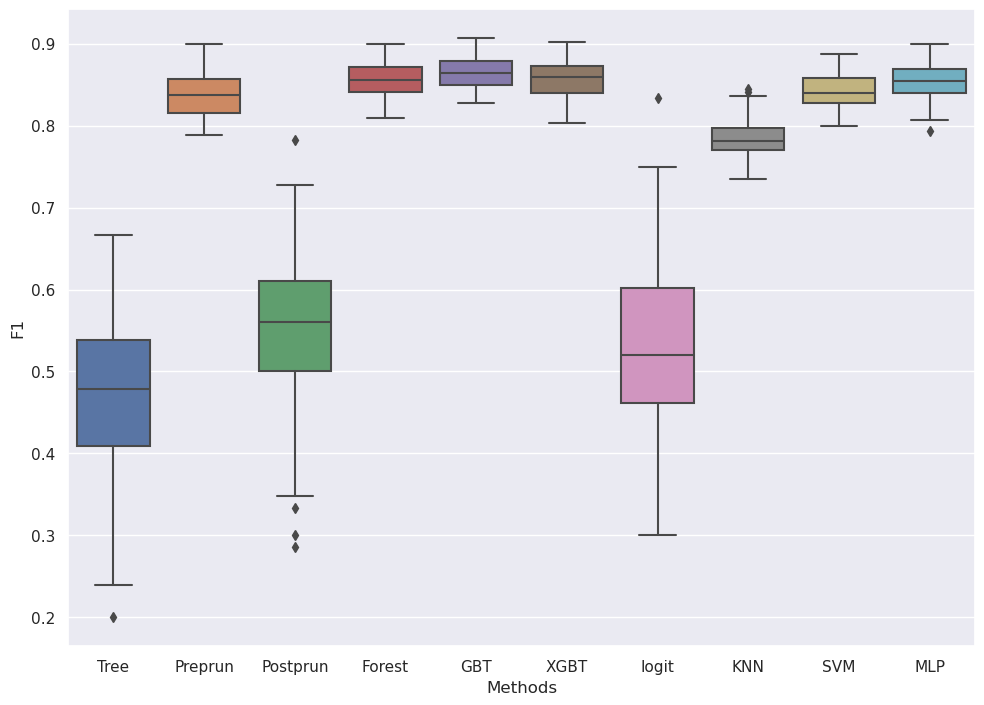

In [171]:
sns.boxplot(df, x = 'Methods', y = 'F1')